# **Dependencies**

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
!pip uninstall transformer
!pip install git+https://github.com/huggingface/transformers@v4.45.1
!pip install mamba-ssm[causal-conv1d]==2.2.4 --no-build-isolation
!pip install rouge-score
!pip install grad-cam

  Cloning https://github.com/huggingface/transformers (to revision v4.45.1) to /tmp/pip-req-build-2bgxbntt
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-2bgxbntt
  Running command git checkout -q 55e4b04b90a7cb7e41a16dd17efed6fcbd70be0f
  Resolved https://github.com/huggingface/transformers to commit 55e4b04b90a7cb7e41a16dd17efed6fcbd70be0f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 33.5 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.45.1-py3-none-any.whl size=9881229 sha256=203014f354fb8eb6d1422c22c0366b61da6d71ff97e40a1f4b3d055d4a5bcf39
  Stored in directory: /tmp/pip-ephem-wheel-cache-_pfj6a4d/wheels/07/92/57/66ffa33aa7d13ddca9d12dcc92092d6a806fc6eca7ea03b7b2
Successfully built transformers
  Attempting uninstall: tokenizers
    Found exist

# **Data Preprocessing , DataSet and DataLoaders**

In [3]:
import os
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import GPT2Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchvision import models
import math
from torch.cuda.amp import GradScaler, autocast
from transformers import get_cosine_schedule_with_warmup
from peft import get_peft_model, LoraConfig, TaskType
from tqdm import tqdm
import pandas as pd
import numpy as np
import gc
import re
from transformers import BitsAndBytesConfig
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

In [4]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


# **Configuration**

In [5]:
XML_REPORTS_PATH = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_reports/ecgen-radiology/"
IMAGES_PATH      = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/"

# Model & Training Params
TOKENIZER_NAME   = "gpt2"
BATCH_SIZE       = 4
MAX_SEQ_LENGTH   = 256
IMAGE_SIZE       = 224

# Data Split Params (R2Gen-style ratios commonly used in IU-Xray literature)
TRAIN_RATIO      = 0.80  # train
VALID_RATIO      = 0.10  # val
TEST_RATIO       = 0.10  # test
RANDOM_STATE     = 42
RAMDOM_SEED      = 9223
assert abs(TRAIN_RATIO + VALID_RATIO + TEST_RATIO - 1.0) < 1e-6, "Ratios must sum to 1."

In [6]:
import pandas as pd
import re

# --- Step 1: Load your new CSV file (No change) ---
CHEXPERT_CSV_PATH = "/kaggle/input/iu-chexpert-labels/final_labeled_reports_with_study_id.csv"
labels_df = pd.read_csv(CHEXPERT_CSV_PATH)

# <<< FIX 1: Define BOTH the source and target label orders >>>
# This is the order of columns as they appear in your new CSV file.
SOURCE_ORDER_FROM_CSV = [
    'No Finding',
    'Enlarged Cardiomediastinum',
    'Cardiomegaly',
    'Lung Lesion',
    'Lung Opacity',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices'
]

# This is the correct order that your pre-trained MambaVision model expects.
TARGET_MODEL_ORDER = [
    'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
    'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax',
    'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices', 'No Finding'
]

# --- Step 2: Extract Study Numbers (No change) ---
def get_study_num_from_id(study_id):
    match = re.search(r'(\d+)', str(study_id))
    if match:
        return match.group(1)
    return None

labels_df['study_num'] = labels_df['study_id'].apply(get_study_num_from_id)
labels_df.dropna(subset=['study_num'], inplace=True)
labels_df.set_index('study_num', inplace=True)

# --- Step 3: Create a lookup dictionary with named labels (No change) ---
# We load the data using the CSV's column order first.
# The result is a dict of dicts: {'study_id': {'No Finding': 1.0, 'Cardiomegaly': 0.0, ...}}
label_lookup_by_name = labels_df[SOURCE_ORDER_FROM_CSV].fillna(0.0).to_dict(orient='index')


# <<< FIX 2: Create the final lookup by reordering the labels for each study >>>
# This new step ensures the final list of labels is in the TARGET_MODEL_ORDER.
label_lookup = {}
for study_num, labels_dict in label_lookup_by_name.items():
    # For each study, build a new list by looking up the labels in the correct target order.
    reordered_labels = [labels_dict[label_name] for label_name in TARGET_MODEL_ORDER]
    label_lookup[study_num] = reordered_labels

print(f"Loaded and reordered {len(label_lookup)} studies with CheXpert labels.")

# --- Verification Step ---
# Let's print an example to prove the reordering worked correctly.
if label_lookup:
    first_key = next(iter(label_lookup))
    
    print("\n--- Verification ---")
    print(f"Original order from CSV: {SOURCE_ORDER_FROM_CSV}")
    print(f"Target order for Model:  {TARGET_MODEL_ORDER}")
    
    print(f"\nOriginal Labels for study '{first_key}':")
    print({k: v for k, v in label_lookup_by_name[first_key].items()})

    print(f"\nReordered Label Vector for study '{first_key}' (this will be fed to the model):")
    print(label_lookup[first_key])

Loaded and reordered 3927 studies with CheXpert labels.

--- Verification ---
Original order from CSV: ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Lesion', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
Target order for Model:  ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices', 'No Finding']

Original Labels for study '1':
{'No Finding': 1.0, 'Enlarged Cardiomediastinum': 0.0, 'Cardiomegaly': 0.0, 'Lung Lesion': 0.0, 'Lung Opacity': 0.0, 'Edema': 0.0, 'Consolidation': 0.0, 'Pneumonia': 0.0, 'Atelectasis': 0.0, 'Pneumothorax': 0.0, 'Pleural Effusion': 0.0, 'Pleural Other': 0.0, 'Fracture': 0.0, 'Support Devices': 0.0}

Reordered Label Vector for study '1' (this will be fed to the model):
[0.0, 0.0

In [7]:
import re

_punct_to_remove = re.compile(r'[?*;!%^&_+():\[\]{}"\\/]+')
_multiple_spaces = re.compile(r'\s{2,}')
_multiple_periods = re.compile(r'\.{2,}')

def clean_text(text):
    if not text or not isinstance(text, str):
        return ""

    text = text.lower().strip()
    text = text.replace('xxxx', '') # Remove placeholder
    text = text.replace('\n', ' ').replace('\r', ' ') # Normalize whitespace

    # Keep commas and periods, but remove other punctuation
    text = _punct_to_remove.sub('', text)
    
    # Standardize spacing around periods and commas
    text = re.sub(r'\s*([,.])\s*', r' \1 ', text)
    text = re.sub(r'\btelephone\b', '', text, flags=re.IGNORECASE)
    # Collapse multiple spaces and periods
    text = _multiple_spaces.sub(' ', text)
    text = _multiple_periods.sub(' . ', text) # Ensure space around periods

    return text.strip()

def extract_patient_id_from_xml(xml_path):
    """
    Derive a stable patient_id for IU X-ray:
    - Prefer deriving from the first parentImage id 'CXR####_IM-...'
      -> returns 'PID_####'
    - Fallback to numeric digits in the XML filename stem.
    """
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        parent = root.find(".//parentImage")
        if parent is not None:
            pid_guess = parent.get('id') or ""
            m = re.search(r'CXR(\d+)', pid_guess)
            if m:
                return f"PID_{m.group(1)}"
    except Exception:
        pass
    stem = os.path.splitext(os.path.basename(xml_path))[0]
    m2 = re.search(r'(\d+)', stem)
    return f"PID_{m2.group(1) if m2 else stem}"

def create_data_manifest(xml_dir, img_dir, tokenizer=None, max_seq_length=512):
    """
    Build per-study multi-view manifest with patient_id.
    Returns list of dicts:
      {
        'patient_id': str,
        'image_paths': [list of .png paths for one study],
        'report_text': str   # clean concatenated findings + impression
      }
    """
    manifest = []
    xml_files = glob(os.path.join(xml_dir, "*.xml"))
    print(f"Scanning {len(xml_files)} XML files to create manifest...")

    for xml_file in tqdm(xml_files, desc="Scanning XMLs"):
        try:
            study_num = os.path.splitext(os.path.basename(xml_file))[0]
            tree = ET.parse(xml_file)
            root = tree.getroot()

            impression_node = root.find(".//AbstractText[@Label='IMPRESSION']")
            findings_node   = root.find(".//AbstractText[@Label='FINDINGS']")
            impression_text = clean_text(impression_node.text if impression_node is not None else "")
            findings_text   = clean_text(findings_node.text   if findings_node   is not None else "")
            if not findings_text and not impression_text:
                continue

            full_report = f"<SECTION_FINDINGS> {findings_text} <SECTION_IMPRESSION> {impression_text} <|endoftext|>"
            image_nodes = root.findall(".//parentImage")
            seen = set()
            image_paths = []
            for node in image_nodes:
                image_filename = (node.get('id') or "") + ".png"
                if not image_filename or image_filename in seen:
                    continue
                seen.add(image_filename)
                image_path = os.path.join(img_dir, image_filename)
                if os.path.exists(image_path):
                    image_paths.append(image_path)
            if not image_paths:
                continue

            patient_id = extract_patient_id_from_xml(xml_file)
            chexpert_labels = label_lookup.get(study_num, [0.0] * len(CHEXPERT_LABELS))
            manifest.append({
                'patient_id': patient_id,
                'image_paths': image_paths,
                'report_text': full_report,
                'chexpert_labels': chexpert_labels
            })
        except Exception as e:
            print(f"Warning: Could not process {os.path.basename(xml_file)}. Error: {e}")
    return manifest


In [8]:
class IUXRayDataset(Dataset):
    def __init__(self, manifest, tokenizer, image_transform=None, max_seq_length=512):
        self.manifest = manifest
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        item = self.manifest[idx]
        report_text = item['report_text']
        image_paths = item['image_paths']

        image_tensors = []
        for p in image_paths:
            # Load image with PIL and convert to RGB
            image = Image.open(p).convert('RGB')
            
            if self.image_transform:
                # Convert PIL image to NumPy array for Albumentations
                image_np = np.array(image)
                # Apply transformations
                transformed = self.image_transform(image=image_np)
                image_tensor = transformed['image']
            else:
                # Default minimal transform if none provided
                image_tensor = transforms.ToTensor()(image)
            
            image_tensors.append(image_tensor)

        # Tokenization remains the same
        tokenized = self.tokenizer(
            report_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_seq_length,
            return_tensors="pt",
            add_special_tokens=True,
        )

        input_ids = tokenized["input_ids"].squeeze(0)
        attention_mask = tokenized["attention_mask"].squeeze(0)
        labels = input_ids.clone()
        labels[attention_mask == 0] = -100

        return {
            "images": image_tensors,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "image_paths": image_paths,
            "patient_id": item.get("patient_id", None),
            "chexpert_labels": torch.tensor(item['chexpert_labels'], dtype=torch.float)
        }

In [9]:
from transformers import GPT2TokenizerFast

# --- THIS IS THE KEY CHANGE ---

# 1. Define the path to your new tokenizer directory
TOKENIZER_PATH = "/kaggle/input/mimic-cxr-tokenizer" # Or the path where you saved it

# 2. Load your custom tokenizer directly from that path
#    All your special tokens and pad_token settings are already saved in this folder!
print(f"Loading custom tokenizer from: {TOKENIZER_PATH}")
tokenizer = GPT2TokenizerFast.from_pretrained(TOKENIZER_PATH)

# # --- End of Change ---


# Sanity check to verify it loaded correctly
print("\n--- Verifying Custom Tokenizer ---")
print(f"Tokenizer vocabulary size: {len(tokenizer)}")
print(f"Pad token: '{tokenizer.pad_token}', ID: {tokenizer.pad_token_id}")
print(f"Special tokens map: {tokenizer.special_tokens_map}")

# Test a medical term to see the difference!
medical_term = "cardiomegaly"
tokens_before = GPT2TokenizerFast.from_pretrained('gpt2').tokenize(medical_term)
tokens_after = tokenizer.tokenize(medical_term)

print(f"\nTokenization of '{medical_term}':")
print(f"  - Before (Standard GPT-2): {tokens_before}")
print(f"  - After (Custom Tokenizer): {tokens_after}") # Should be a single token or fewer tokens
print("-" * 30)

Loading custom tokenizer from: /kaggle/input/mimic-cxr-tokenizer

--- Verifying Custom Tokenizer ---
Tokenizer vocabulary size: 53263
Pad token: '<|endoftext|>', ID: 50256
Special tokens map: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<SECTION_FINDINGS>', '<SECTION_IMPRESSION>']}


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]


Tokenization of 'cardiomegaly':
  - Before (Standard GPT-2): ['card', 'i', 'ome', 'g', 'aly']
  - After (Custom Tokenizer): ['cardi', 'omegaly']
------------------------------


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
def make_collate_fn(pad_token_id: int):
    def _collate(batch):
        if len(batch) == 0:
            raise ValueError("Empty batch received by collate_fn.")
        image_lists = [it['images'] for it in batch]
        image_paths_lists = [it['image_paths'] for it in batch]
        input_ids_list = [it['input_ids'] for it in batch]
        labels_list = [it['labels'] for it in batch]
        chexpert_labels = torch.stack([it['chexpert_labels'] for it in batch])
        max_views = max(len(images) for images in image_lists)

        batch_images, mask = [], []
        for images in image_lists:
            if len(images) == 0:
                raise ValueError("Found a sample with zero images/views. Check your manifest.")
            last_image = images[-1]
            padded = images + [last_image] * (max_views - len(images))
            batch_images.append(torch.stack(padded))  # (V,3,H,W)
            mask.append([1] * len(images) + [0] * (max_views - len(images)))

        batch_images = torch.stack(batch_images)                # (B,V,3,H,W)
        view_mask   = torch.tensor(mask, dtype=torch.bool)      # (B,V)
        input_ids     = torch.stack([it['input_ids'] for it in batch])
        attention_mask= torch.stack([it['attention_mask'] for it in batch])
        labels        = torch.stack([it['labels'] for it in batch]).clone()  # (B,T)

        labels[attention_mask == 0] = -100

        return {
            'images': batch_images,
            'view_mask': view_mask,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'image_paths': image_paths_lists,
            'chexpert_labels': chexpert_labels
        }
    return _collate

collate_fn = make_collate_fn(tokenizer.pad_token_id)

# **Loaded Data Visualization**

In [11]:

import os, random, numpy as np, torch

def set_global_seed(seed: int = 9223, deterministic: bool = True):
    # Python & NumPy
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # cuDNN / deterministic behavior
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        # Slightly faster but less reproducible
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

    # Torch compile caches, dataloader reproducibility knobs (optional)
    os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":4096:8")  # for determinism on some ops
    # If using torch>=2.0, some ops may still be nondeterministic; see PyTorch docs.

# Call once, before any randomness-dependent code (tokenizer/dataloaders/models)
GLOBAL_SEED = 9223
set_global_seed(GLOBAL_SEED, deterministic=True)


In [12]:
def _worker_init_fn(worker_id):
    # Ensures each worker has a distinct, reproducible seed
    worker_seed = (GLOBAL_SEED + worker_id) % (2**32)
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(GLOBAL_SEED)


In [13]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the image size your MambaVision model expects
IMAGE_SIZE = 224 # Or 384, etc.

# This is a balanced and safe pipeline for training
train_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),
    A.ShiftScaleRotate(
        shift_limit=0.05,      # Max 5% shift in x/y
        scale_limit=0.1,       # Max 10% zoom in/out
        rotate_limit=7.5,       # Max 15 degrees rotation
        p=0.8                   # Apply this transform 90% of the time
    ),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(
        brightness_limit=0.15,  # Max 20% change in brightness
        contrast_limit=0.15,    # Max 20% change in contrast
        p=0.7# Apply this 80% of the time
    ),

    A.Normalize(
        mean=[0.485, 0.456, 0.406], # Standard ImageNet mean
        std=[0.229, 0.224, 0.225]   # Standard ImageNet std
    ),
    ToTensorV2(),
])

# The validation transform should be minimal: just resize and normalize.
val_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Scanning 3955 XML files to create manifest...


Scanning XMLs: 100%|██████████| 3955/3955 [00:45<00:00, 86.14it/s]

Total multi-view studies in manifest: 3826

Data successfully split (patient-level, multi-view, no leakage):
Unique patients total: 3826
Train patients: 3061, Val patients: 383, Test patients: 382
Training studies:   3061
Validation studies: 383
Test studies:       382

--- Creating Pathology-Aware Weighted Sampler for TRAINING data ---
Sampler created for 3061 training samples.

DataLoaders created correctly: Training is balanced, Validation and Test reflect the real-world distribution.

PyTorch DataLoaders are ready!

--- Verifying a sample batch from the train_loader ---


Batch keys: dict_keys(['images', 'view_mask', 'input_ids', 'attention_mask', 'labels', 'image_paths', 'chexpert_labels'])
Image tensor shape:      torch.Size([4, 2, 3, 224, 224])
View mask shape:         torch.Size([4, 2])
Input IDs tensor shape:  torch.Size([4, 256])
Attention mask shape:    torch.Size([4, 256])
Labels tensor shape:     torch.Size([4, 256])
First study image_paths: ['/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR3523_IM-1721-1001.png', '/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR3523_IM-1721-1002.png']


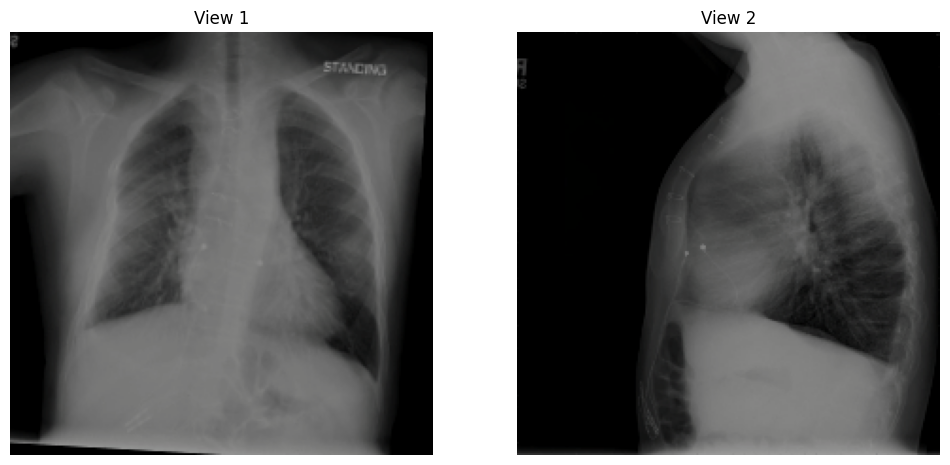


--- Sample Report (Decoded) ---
 changes post bilateral thoracotomy and sternotomy . intact . stable position of the epicardial . mild cardiomegaly . the lungs are clear . bilateral small pleural effusions .  1 . stable postop changes with mild cardiomegaly . 2 . small bilateral pleural effusions . 
--------------------------------------------------


In [14]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
CHEXPERT_LABELS = [
    'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
    'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax',
    'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices', 'No Finding'
]

# --- Create manifest for multi-view ---
# 5) Build manifest and patient-level split

full_manifest = create_data_manifest(
    XML_REPORTS_PATH,
    IMAGES_PATH,
    tokenizer,
    max_seq_length=MAX_SEQ_LENGTH
)
print(f"Total multi-view studies in manifest: {len(full_manifest)}")

# Unique patients and shuffled split
all_patients = sorted({m['patient_id'] for m in full_manifest})
random.Random(RANDOM_STATE).shuffle(all_patients)

n_patients = len(all_patients)
n_train = int(round(TRAIN_RATIO * n_patients))
n_val   = int(round(VALID_RATIO * n_patients))
n_test  = n_patients - n_train - n_val

train_patients = set(all_patients[:n_train])
val_patients   = set(all_patients[n_train:n_train+n_val])
test_patients  = set(all_patients[n_train+n_val:])

def filter_by_patients(manifest, keep_patients):
    return [m for m in manifest if m['patient_id'] in keep_patients]

train_manifest = filter_by_patients(full_manifest, train_patients)
val_manifest   = filter_by_patients(full_manifest, val_patients)
test_manifest  = filter_by_patients(full_manifest, test_patients)

print("\nData successfully split (patient-level, multi-view, no leakage):")
print(f"Unique patients total: {n_patients}")
print(f"Train patients: {len(train_patients)}, Val patients: {len(val_patients)}, Test patients: {len(test_patients)}")
print(f"Training studies:   {len(train_manifest)}")
print(f"Validation studies: {len(val_manifest)}")
print(f"Test studies:       {len(test_manifest)}")


# --- Create Datasets and DataLoaders for multi-view ---
# 6) Datasets and DataLoaders

train_dataset = IUXRayDataset(train_manifest, tokenizer, train_transform, max_seq_length=MAX_SEQ_LENGTH)
val_dataset   = IUXRayDataset(val_manifest,   tokenizer, val_transform, max_seq_length=MAX_SEQ_LENGTH)
test_dataset  = IUXRayDataset(test_manifest,  tokenizer, val_transform, max_seq_length=MAX_SEQ_LENGTH)

import numpy as np
from torch.utils.data import WeightedRandomSampler

print("\n--- Creating Pathology-Aware Weighted Sampler for TRAINING data ---")

# --- 1. Extract labels and create a DataFrame for robust counting ---
train_labels_list = [item['chexpert_labels'] for item in train_manifest]
train_df = pd.DataFrame(train_labels_list, columns=CHEXPERT_LABELS)

# --- THE FIX IS HERE: We now explicitly count ONLY the positive (1.0) cases ---
label_counts = (train_df == 1.0).sum(axis=0).values
# --- END OF FIX ---

total_samples = len(train_manifest)
prevalence = label_counts / (total_samples + 1e-8)
label_weights = np.clip(1.0 / prevalence, 1.0, 20.0) # Cap weights to prevent extreme values

# --- The rest of the logic remains the same, but now uses the correct counts ---
sample_weights = []
no_finding_idx = CHEXPERT_LABELS.index('No Finding')

for item in train_manifest:
    labels = np.array(item['chexpert_labels'])
    if labels[no_finding_idx] == 1:
        sample_weights.append(1.0)
        continue
    
    # We check for positive labels ( > 0 is a safe way to get only 1.0)
    positive_label_indices = np.where(labels[:-1] > 0)[0]
    
    if len(positive_label_indices) == 0:
        sample_weights.append(1.0)
    else:
        rarest_finding_weight = np.max(label_weights[positive_label_indices])
        sample_weights.append(rarest_finding_weight)

train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)
print(f"Sampler created for {len(sample_weights)} training samples.")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Sampler handles shuffling
    sampler=train_sampler,
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True
)

# The VALIDATION loader DOES NOT use a sampler
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # Use False for consistent evaluation
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True
)

# The TEST loader DOES NOT use a sampler
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # Always False for the final test
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True
)

print("\nDataLoaders created correctly: Training is balanced, Validation and Test reflect the real-world distribution.")

print("\nPyTorch DataLoaders are ready!")

print("\n--- Verifying a sample batch from the train_loader ---")

# --- Fetch one batch
# 7) Quick sanity check: one batch + visualize views

sample_batch = next(iter(train_loader))
print(f"Batch keys: {sample_batch.keys()}")
print(f"Image tensor shape:      {sample_batch['images'].shape}")       # (B,V,3,H,W)
print(f"View mask shape:         {sample_batch['view_mask'].shape}")    # (B,V)
print(f"Input IDs tensor shape:  {sample_batch['input_ids'].shape}")    # (B,T)
print(f"Attention mask shape:    {sample_batch['attention_mask'].shape}")
print(f"Labels tensor shape:     {sample_batch['labels'].shape}")
print(f"First study image_paths: {sample_batch['image_paths'][0]}")

# Visualize all (non-padded) views for a random study in the batch
idx_to_show = random.randint(0, sample_batch['images'].size(0) - 1)
images_to_show = sample_batch['images'][idx_to_show]  # (V,3,H,W)
view_mask = sample_batch['view_mask'][idx_to_show]    # (V,)
num_views = images_to_show.size(0)

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

valid_indices = [i for i in range(num_views) if view_mask[i].item() == 1]
plt.figure(figsize=(6 * len(valid_indices), 6))
for plot_idx, i in enumerate(valid_indices, start=1):
    img_tensor = images_to_show[i]
    img_display = (img_tensor * std) + mean
    img_display = transforms.ToPILImage()(img_display.clamp(0, 1))
    plt.subplot(1, len(valid_indices), plot_idx)
    plt.imshow(img_display)
    plt.title(f"View {i+1}")
    plt.axis('off')
plt.show()

# Decode report for that study
input_ids_display = sample_batch['input_ids'][idx_to_show]
report_display = tokenizer.decode(input_ids_display, skip_special_tokens=True)
print("\n--- Sample Report (Decoded) ---")
print(report_display)
print("-" * 50)




--- Class Distribution of Positive Cases (Text Summary) ---
                            Train Set Count  Validation Set Count  Total
Enlarged Cardiomediastinum              136                    17    153
Cardiomegaly                            483                    57    540
Lung Opacity                            510                    70    580
Lung Lesion                             135                    15    150
Edema                                    41                     6     47
Consolidation                            51                     5     56
Pneumonia                                64                     9     73
Atelectasis                             188                    27    215
Pneumothorax                             31                     5     36
Pleural Effusion                        113                    17    130
Pleural Other                            38                     3     41
Fracture                                111                    

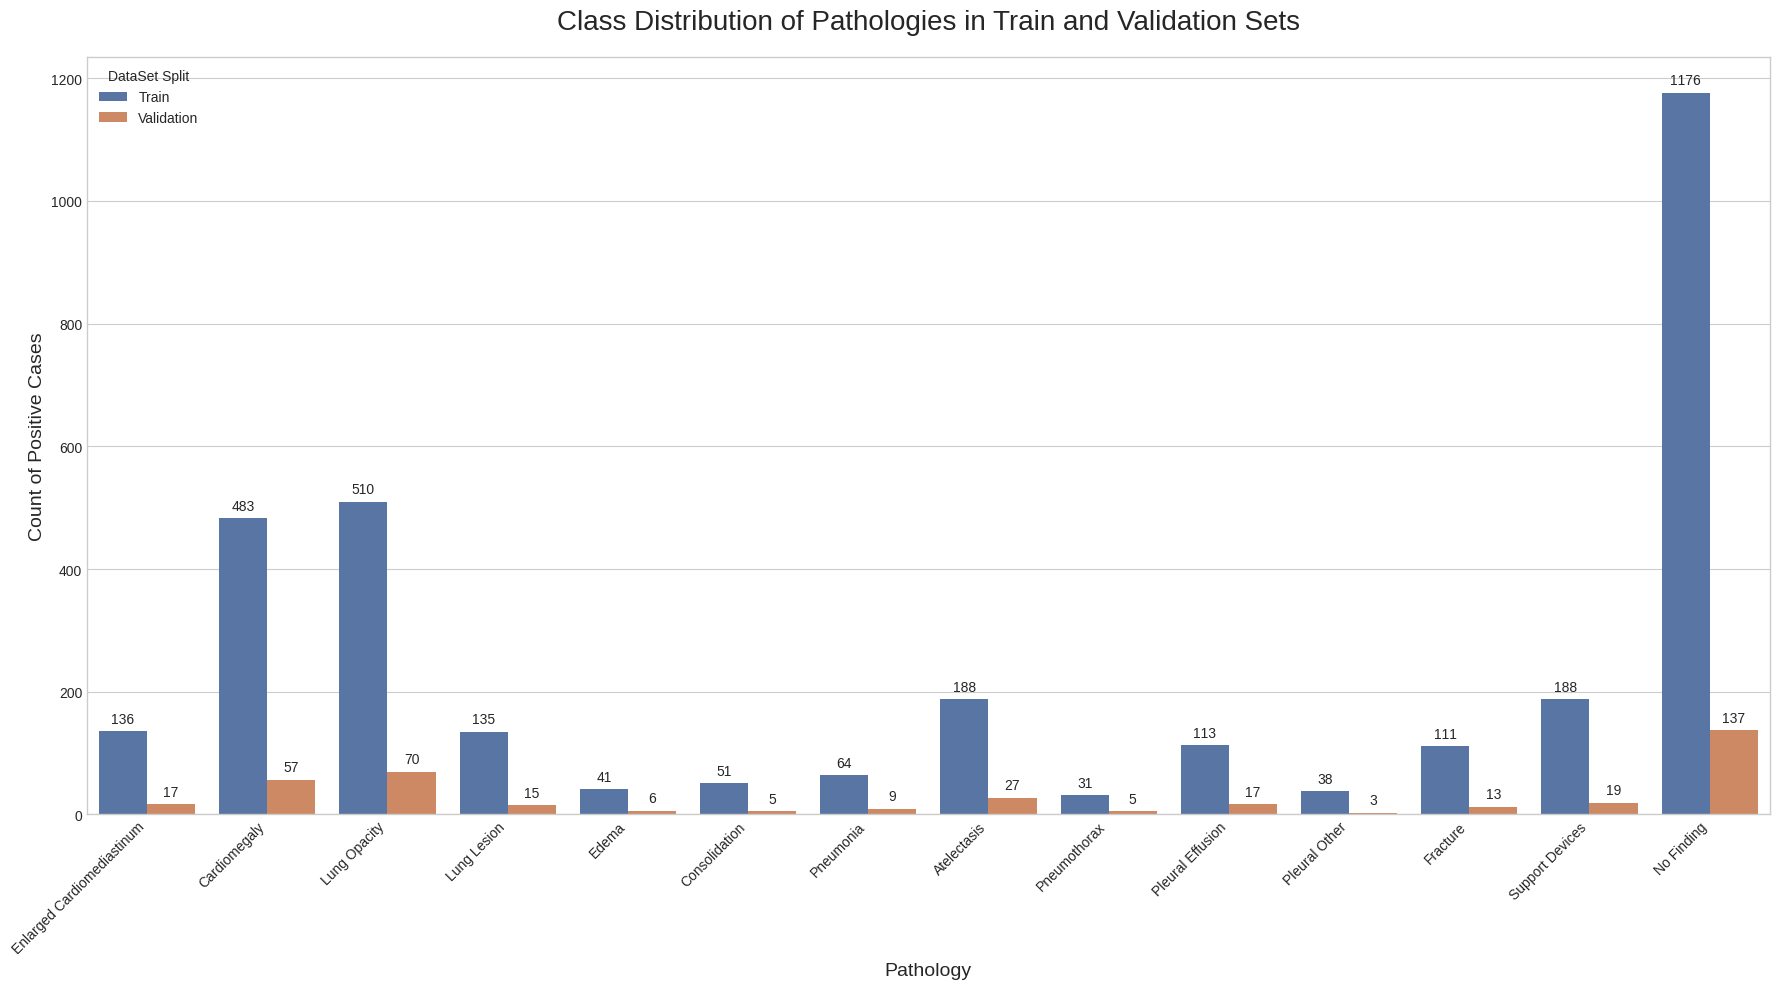

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure CHEXPERT_LABELS and your manifests are defined
# CHEXPERT_LABELS = ['Enlarged Cardiomediastinum', 'Cardiomegaly', ...]
# train_manifest = [...]
# val_manifest = [...]

# --- 1. Extract Labels into Pandas DataFrames ---
train_labels_list = [item['chexpert_labels'] for item in train_manifest]
train_df = pd.DataFrame(train_labels_list, columns=CHEXPERT_LABELS)

val_labels_list = [item['chexpert_labels'] for item in val_manifest]
val_df = pd.DataFrame(val_labels_list, columns=CHEXPERT_LABELS)


# --- 2. Calculate the count of POSITIVE findings for each class ---

# --- THE FIX IS HERE ---
# Instead of a simple .sum(), we create a boolean mask for values equal to 1.0
# and then sum the True values (which count as 1).
# This correctly counts only the positive cases.
train_counts = (train_df == 1.0).sum(axis=0).astype(int)
val_counts = (val_df == 1.0).sum(axis=0).astype(int)


# --- 2.5: Print the Class Distribution as a Text Table ---
summary_df = pd.DataFrame({
    'Train Set Count': train_counts,
    'Validation Set Count': val_counts
})
summary_df['Total'] = summary_df['Train Set Count'] + summary_df['Validation Set Count']

print("\n" + "="*55)
print("--- Class Distribution of Positive Cases (Text Summary) ---")
print("="*55)
print(summary_df)
print("="*55 + "\n")


# --- 3. Prepare data for plotting ---
plot_data = pd.DataFrame({
    'Pathology': train_counts.index,
    'Train': train_counts.values,
    'Validation': val_counts.values
})
plot_data_melted = plot_data.melt(
    id_vars='Pathology',
    var_name='DataSet Split',
    value_name='Number of Positive Cases'
)


# --- 4. Create the plot ---
print("\n--- Generating Class Distribution Plot ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(
    data=plot_data_melted,
    x='Pathology',
    y='Number of Positive Cases',
    hue='DataSet Split',
    ax=ax,
    palette={'Train': '#4c72b0', 'Validation': '#dd8452'}
)

# --- 5. Formatting and Display ---
ax.set_title('Class Distribution of Pathologies in Train and Validation Sets', fontsize=20, pad=20)
ax.set_xlabel('Pathology', fontsize=14)
ax.set_ylabel('Count of Positive Cases', fontsize=14)
plt.xticks(rotation=45, ha='right')
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 9),
        textcoords='offset points'
    )
plt.tight_layout()
plt.show()

Analyzer initialized with 3826 reports.

--- Starting Text Quality Analysis ---


Calculating basic stats:   0%|          | 0/3826 [00:00<?, ?it/s]

Analyzing sections:   0%|          | 0/3826 [00:00<?, ?it/s]

Checking for placeholders:   0%|          | 0/3826 [00:00<?, ?it/s]

--- Analysis Complete ---

      Radiology Report Text Quality Analysis Summary

[1] Reports flagged as TOO SHORT (< 15 words): 53
  - ID: PID_3585, Words: 8, Text: '<SECTION_FINDINGS>  <SECTION_IMPRESSION> no active cardiopulmonary disease . <|e...'
  - ID: PID_2089, Words: 7, Text: '<SECTION_FINDINGS>  <SECTION_IMPRESSION> no active disease . <|endoftext|>...'
  - ID: PID_3200, Words: 13, Text: '<SECTION_FINDINGS>  <SECTION_IMPRESSION> heart size is normal and the lungs are ...'

[2] Reports flagged as TOO LONG (> 300 words): 0

[3] Reports flagged as REPETITIVE (score < 0.4): 2
  - ID: PID_2415, Score: 0.38, Text: '<SECTION_FINDINGS> the heart is mildly enlarged . the lungs are hypoinflated wit...'
  - ID: PID_518, Score: 0.38, Text: '<SECTION_FINDINGS> stable normal cardiac size and contour , unremarkable mediast...'

[4] Reports flagged with cleaning ARTIFACTS/PLACEHOLDERS: 0

[5] Reports flagged with IMBALANCED sections: 663
  - ID: PID_3198, Findings Words: 0, Impression Words: 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


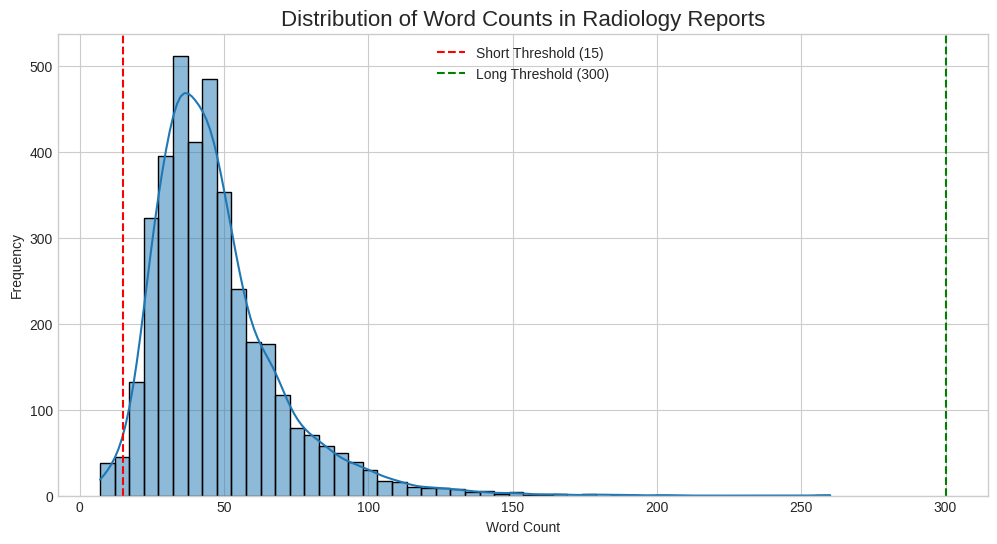

In [16]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# This script assumes you have already created 'full_manifest'
# full_manifest = create_data_manifest(...)

class ReportAnalyzer:
    """
    A tool to analyze a manifest of radiology reports for common textual
    inconsistencies that could negatively impact model training.
    """
    def __init__(self, manifest):
        if not manifest:
            raise ValueError("Input manifest cannot be empty.")
        self.manifest = manifest
        self.df = pd.DataFrame(manifest)
        print(f"Analyzer initialized with {len(self.df)} reports.")

        # --- Configuration for analysis thresholds ---
        self.CONFIG = {
            "SHORT_REPORT_WORDS_THRESHOLD": 15,
            "LONG_REPORT_WORDS_THRESHOLD": 300,
            "LOW_REPETITION_SCORE_THRESHOLD": 0.4, # Lower score = more repetitive
            "SECTION_IMBALANCE_RATIO": 10.0, # e.g., Findings is 10x longer than Impression
            "PLACEHOLDER_PATTERNS": [
                r"dictated by", r"electronically signed", r"dr\.", r"\smd\s",
                r"report status", r"final report", r"telephone", r"page \d of \d"
            ]
        }

    def _calculate_stats(self, text):
        """Calculates basic statistics for a single report."""
        words = text.split()
        word_count = len(words)
        char_count = len(text)
        
        # Repetition Score: Ratio of unique words to total words.
        # A low score indicates high repetition (e.g., "normal normal normal").
        if word_count > 0:
            repetition_score = len(set(words)) / word_count
        else:
            repetition_score = 0.0
            
        return word_count, char_count, repetition_score

    def _analyze_sections(self, text):
        """Analyzes the content and balance of FINDINGS and IMPRESSION sections."""
        try:
            findings_match = re.search(r"<SECTION_FINDINGS>(.*?)<SECTION_IMPRESSION>", text, re.DOTALL)
            impression_match = re.search(r"<SECTION_IMPRESSION>(.*?)<\|endoftext\|>", text, re.DOTALL)

            findings_text = findings_match.group(1).strip() if findings_match else ""
            impression_text = impression_match.group(1).strip() if impression_match else ""

            findings_len = len(findings_text.split())
            impression_len = len(impression_text.split())

            return findings_len, impression_len
        except Exception:
            return 0, 0

    def _check_for_placeholders(self, text):
        """Checks for the presence of common placeholder text."""
        text_lower = text.lower()
        found_patterns = []
        for pattern in self.CONFIG["PLACEHOLDER_PATTERNS"]:
            if re.search(pattern, text_lower):
                found_patterns.append(pattern)
        return found_patterns if found_patterns else None

    def run_analysis(self):
        """
        Runs the full analysis suite on the manifest and stores results
        in the internal DataFrame.
        """
        print("\n--- Starting Text Quality Analysis ---")
        
        # Use tqdm for progress tracking with pandas
        tqdm.pandas(desc="Calculating basic stats")
        stats = self.df['report_text'].progress_apply(self._calculate_stats)
        self.df[['word_count', 'char_count', 'repetition_score']] = pd.DataFrame(stats.tolist(), index=self.df.index)

        tqdm.pandas(desc="Analyzing sections")
        sections = self.df['report_text'].progress_apply(self._analyze_sections)
        self.df[['findings_len', 'impression_len']] = pd.DataFrame(sections.tolist(), index=self.df.index)

        tqdm.pandas(desc="Checking for placeholders")
        self.df['placeholders_found'] = self.df['report_text'].progress_apply(self._check_for_placeholders)

        print("--- Analysis Complete ---\n")
        return self.df

    def print_summary(self):
        """Prints a summary of the findings and shows examples."""
        if 'word_count' not in self.df.columns:
            print("Analysis has not been run yet. Please call .run_analysis() first.")
            return

        print("="*60)
        print("      Radiology Report Text Quality Analysis Summary")
        print("="*60)

        # 1. Very Short Reports
        short_reports = self.df[self.df['word_count'] < self.CONFIG['SHORT_REPORT_WORDS_THRESHOLD']]
        print(f"\n[1] Reports flagged as TOO SHORT (< {self.CONFIG['SHORT_REPORT_WORDS_THRESHOLD']} words): {len(short_reports)}")
        if not short_reports.empty:
            for _, row in short_reports.head(3).iterrows():
                print(f"  - ID: {row['patient_id']}, Words: {row['word_count']}, Text: '{row['report_text'][:80]}...'")

        # 2. Very Long Reports
        long_reports = self.df[self.df['word_count'] > self.CONFIG['LONG_REPORT_WORDS_THRESHOLD']]
        print(f"\n[2] Reports flagged as TOO LONG (> {self.CONFIG['LONG_REPORT_WORDS_THRESHOLD']} words): {len(long_reports)}")
        if not long_reports.empty:
            for _, row in long_reports.head(3).iterrows():
                print(f"  - ID: {row['patient_id']}, Words: {row['word_count']}")

        # 3. Highly Repetitive Reports
        repetitive_reports = self.df[self.df['repetition_score'] < self.CONFIG['LOW_REPETITION_SCORE_THRESHOLD']]
        print(f"\n[3] Reports flagged as REPETITIVE (score < {self.CONFIG['LOW_REPETITION_SCORE_THRESHOLD']}): {len(repetitive_reports)}")
        if not repetitive_reports.empty:
            for _, row in repetitive_reports.head(3).iterrows():
                print(f"  - ID: {row['patient_id']}, Score: {row['repetition_score']:.2f}, Text: '{row['report_text'][:80]}...'")

        # 4. Reports with Placeholders
        placeholder_reports = self.df[self.df['placeholders_found'].notna()]
        print(f"\n[4] Reports flagged with cleaning ARTIFACTS/PLACEHOLDERS: {len(placeholder_reports)}")
        if not placeholder_reports.empty:
            for _, row in placeholder_reports.head(3).iterrows():
                print(f"  - ID: {row['patient_id']}, Found: {row['placeholders_found']}")

        # 5. Imbalanced Sections
        imbalanced = self.df[
            ((self.df['findings_len'] / (self.df['impression_len'] + 1e-6)) > self.CONFIG['SECTION_IMBALANCE_RATIO']) |
            ((self.df['impression_len'] / (self.df['findings_len'] + 1e-6)) > self.CONFIG['SECTION_IMBALANCE_RATIO'])
        ]
        print(f"\n[5] Reports flagged with IMBALANCED sections: {len(imbalanced)}")
        if not imbalanced.empty:
            for _, row in imbalanced.head(3).iterrows():
                print(f"  - ID: {row['patient_id']}, Findings Words: {row['findings_len']}, Impression Words: {row['impression_len']}")

        print("\n" + "="*60)
        print("RECOMMENDATIONS:")
        print("- For issues [1], [3], [5]: Review these cases. They may be low-quality and could be excluded from training.")
        print("- For issue [4]: Update your `clean_text` function to remove these common patterns.")
        print("- For issue [2]: Ensure your `MAX_SEQ_LENGTH` is sufficient. These reports will be truncated.")
        print("="*60)

    def plot_word_count_distribution(self):
        """Displays a histogram of the report word counts."""
        if 'word_count' not in self.df.columns:
            print("Analysis has not been run yet. Please call .run_analysis() first.")
            return

        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(12, 6))
        sns.histplot(self.df['word_count'], bins=50, kde=True)
        plt.title('Distribution of Word Counts in Radiology Reports', fontsize=16)
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        plt.axvline(self.CONFIG['SHORT_REPORT_WORDS_THRESHOLD'], color='r', linestyle='--', label=f'Short Threshold ({self.CONFIG["SHORT_REPORT_WORDS_THRESHOLD"]})')
        plt.axvline(self.CONFIG['LONG_REPORT_WORDS_THRESHOLD'], color='g', linestyle='--', label=f'Long Threshold ({self.CONFIG["LONG_REPORT_WORDS_THRESHOLD"]})')
        plt.legend()
        plt.show()


# =======================================================
# ---      MAIN EXECUTION BLOCK      ---
# =======================================================
if __name__ == '__main__' and 'full_manifest' in locals():
    # Create an instance of the analyzer
    analyzer = ReportAnalyzer(full_manifest)

    # Run the analysis
    analysis_df = analyzer.run_analysis()

    # Print the text-based summary report
    analyzer.print_summary()

    # Show the visual plot of word count distribution
    analyzer.plot_word_count_distribution()
    
    # You can now also inspect the 'analysis_df' DataFrame directly
    # for more detailed exploration.
    # print("\n--- Full Analysis DataFrame Head ---")
    # print(analysis_df.head())
else:
    print("Please ensure you have created the 'full_manifest' list before running this script.")
    print("Example: analyzer = ReportAnalyzer(full_manifest); analyzer.run_analysis(); ...")

In [17]:
if 'analysis_df' in locals():
    # Calculate the word count at different percentiles
    p90 = analysis_df['word_count'].quantile(0.90)
    p95 = analysis_df['word_count'].quantile(0.95)
    p98 = analysis_df['word_count'].quantile(0.98)
    p99 = analysis_df['word_count'].quantile(0.99)
    max_wc = analysis_df['word_count'].max()

    print("\n" + "="*50)
    print("      Word Count Percentile Analysis")
    print("="*50)
    print(f"90% of reports have a word count of {p90:.0f} or less.")
    print(f"95% of reports have a word count of {p95:.0f} or less.")
    print(f"98% of reports have a word count of {p98:.0f} or less.")
    print(f"99% of reports have a word count of {p99:.0f} or less.")
    print(f"The absolute longest report has {max_wc:.0f} words.")
    print("="*50)
else:
    print("Please run the ReportAnalyzer first to create 'analysis_df'.")


      Word Count Percentile Analysis
90% of reports have a word count of 75 or less.
95% of reports have a word count of 90 or less.
98% of reports have a word count of 108 or less.
99% of reports have a word count of 124 or less.
The absolute longest report has 260 words.


# **MambaVision**

In [18]:
import torch
import torch.nn as nn
from transformers import AutoModel

class MambaVisionEncoder(nn.Module):
    """
    A unified MambaVision class that can be used for multi-label classification
    (for pre-training) or as a powerful feature encoder for report generation.
    """
    def __init__(self, model_name="nvidia/MambaVision-S-1K", num_labels=14, device="cuda", dropout_rate=0.3,
                 for_report_generation=False, trained_classifier_path=None):
        super().__init__()
        self.device = device
        self.for_report_generation = for_report_generation

        # 1. Load the base MambaVision model from Hugging Face
        self.encoder = AutoModel.from_pretrained(
            model_name,
            trust_remote_code=True
        ).to(device)

        # 2. Infer hidden dimension from the model itself
        self.encoder.eval()
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224, device=device)
            pooled_feats, _ = self.encoder(dummy)
            hidden_dim = pooled_feats.shape[-1]

        print(f"Inferred hidden dimension: {hidden_dim}")

        # 3. Define the classification head (only used if for_report_generation is False)
        self.label_head = nn.Sequential(
            nn.Linear(hidden_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_labels)
        ).to(device)

        # 4. Load pre-trained weights if a path is provided (with robust loading)
        if trained_classifier_path:
            print(f"Loading pre-trained classifier weights from: {trained_classifier_path}")
            checkpoint = torch.load(trained_classifier_path, map_location=device)
            # Handle both raw state_dict and checkpoint dictionaries
            if 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
            else:
                state_dict = checkpoint
            
            # Handle weights from a compiled model (_orig_mod prefix)
            unwrapped_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
            
            # Use strict=False to gracefully handle loading only encoder weights
            # if the saved model doesn't have the classification head.
            self.load_state_dict(unwrapped_state_dict, strict=False)
            print("Successfully loaded pre-trained weights.")

        # 5. Set initial state
        self.encoder.eval()
        self.frozen = False
        self.freeze() # Start with the encoder frozen by default

    def forward(self, image_tensor):
        """
        Forward pass behavior depends on the 'for_report_generation' flag.
        """
        pooled_feats, features = self.encoder(image_tensor)
        
        if self.for_report_generation:
            # Mode 1: Report Generation - Return patch features
            last_stage_features = features[-1]
            patch_tokens = last_stage_features.flatten(2).permute(0, 2, 1)
            return patch_tokens, features
        else:
            # Mode 2: Classification - Return logits
            logits = self.label_head(pooled_feats)
            return logits, {'pooled': pooled_feats, 'patch': features}

    def freeze(self):
        self.frozen = True
        self.encoder.eval()
        print("Freezing encoder layers.")
        for param in self.encoder.parameters():
            param.requires_grad = False

    def unfreeze(self):
        self.frozen = False
        self.encoder.train()
        print("Unfreezing all encoder layers.")
        for param in self.encoder.parameters():
            param.requires_grad = True

    def unfreeze_encoder_top_layers(self, num_levels_to_unfreeze=1):
        if num_levels_to_unfreeze < 0 or num_levels_to_unfreeze > len(self.encoder.model.levels):
            raise ValueError("num_levels_to_unfreeze must be between 0 and 4.")

        self.freeze()
        if num_levels_to_unfreeze > 0:
            print(f"Unfreezing the last {num_levels_to_unfreeze} encoder level(s)...")
            self.frozen = False
            self.encoder.train()
            for i in range(num_levels_to_unfreeze):
                level_to_unfreeze = self.encoder.model.levels[-(i + 1)]
                for param in level_to_unfreeze.parameters():
                    param.requires_grad = True
        else:
            print("Encoder remains frozen.")

# **Main Block**

In [19]:
import torch
import torch.nn as nn
from mamba_ssm import Mamba

class BidirectionalMambaFusion(nn.Module):
    """
    A Bidirectional Mamba layer to fuse a sequence of features.
    It scans the sequence forward and backward to create a globally-aware representation.
    --- ROBUST VERSION WITH INTERMEDIATE NORMALIZATION ---
    """
    def __init__(self, embed_dim, mamba_d_state=16, mamba_d_conv=4, mamba_expand=2):
        super().__init__()
        self.embed_dim = embed_dim

        self.forward_mamba = Mamba(d_model=embed_dim, d_state=mamba_d_state, d_conv=mamba_d_conv, expand=mamba_expand)
        
        # ==================== THE FIX IS ON THIS LINE ====================
        # Changed 'm_d_state' back to the correct variable name 'mamba_d_state'
        self.backward_mamba = Mamba(d_model=embed_dim, d_state=mamba_d_state, d_conv=mamba_d_conv, expand=mamba_expand)
        # ===============================================================

        # Add separate norms to stabilize the output of each Mamba block individually
        self.norm_fwd = nn.LayerNorm(embed_dim)
        self.norm_bwd = nn.LayerNorm(embed_dim)

        # The final norm remains to stabilize the combined output
        self.norm_final = nn.LayerNorm(embed_dim)

    def forward(self, x):
        """
        x: Input tensor of shape (B, Seq_Len, Dim)
        """
        # --- Forward Pass with its own normalization ---
        forward_out = self.forward_mamba(x)
        forward_out = self.norm_fwd(forward_out)

        # --- Backward Pass with its own normalization ---
        x_reversed = torch.flip(x, dims=[1])
        backward_out_reversed = self.backward_mamba(x_reversed)
        backward_out = torch.flip(backward_out_reversed, dims=[1])
        backward_out = self.norm_bwd(backward_out)

        # --- Combine the now-stabilized outputs ---
        fused_output = self.norm_final(forward_out + backward_out)

        return fused_output

In [20]:
class FeedForward(nn.Module):
    """A simple Feed-Forward Network block."""
    def __init__(self, embed_dim, ffn_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, ffn_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ffn_dim, embed_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class HybridMambaAttentionFusionBlock(nn.Module): # Renamed to "Block" for clarity
    """
    The UPDATED HMAF block, now including a Feed-Forward Network.
    """
    def __init__(self, embed_dim, num_heads=8, mamba_d_state=16, mamba_d_conv=4, mamba_expand=2, ffn_dim=None):
        super().__init__()
        if ffn_dim is None:
            ffn_dim = embed_dim * 4 # Standard FFN expansion ratio

        # --- THE FIX IS HERE ---
        # Layer 1: Global Context Scanner (BMF)
        self.bmf = BidirectionalMambaFusion(
            embed_dim=embed_dim,
            mamba_d_state=mamba_d_state,
            mamba_d_conv=mamba_d_conv,
            mamba_expand=mamba_expand
        )
        # --- END OF FIX ---

        self.norm1 = nn.LayerNorm(embed_dim)

        # Layer 2: Fine-grained Local Refiner (Self-Attention)
        self.self_attention = nn.MultiheadAttention(
            embed_dim=embed_dim, 
            num_heads=num_heads, 
            batch_first=True
        )
        self.norm2 = nn.LayerNorm(embed_dim)

        # Layer 3: Feed-Forward Network
        self.ffn = FeedForward(embed_dim, ffn_dim)
        self.norm3 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        mamba_out = self.bmf(x)
        x = self.norm1(x + mamba_out)

        attn_out, _ = self.self_attention(query=x, key=x, value=x)
        x = self.norm2(x + attn_out)

        ffn_out = self.ffn(x)
        x = self.norm3(x + ffn_out)
        
        return x

class StackedHybridMambaAttentionFusion(nn.Module):
    """
    A new module that stacks multiple HMAF blocks.
    """
    def __init__(self, num_layers=2, embed_dim=768, num_heads=8, **kwargs):
        super().__init__()
        self.layers = nn.ModuleList([
            HybridMambaAttentionFusionBlock(embed_dim=embed_dim, num_heads=num_heads, **kwargs)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [21]:
class SpatioViewAwareEmbedding(nn.Module):
    def __init__(self, patch_grid_size: int, num_views: int, embed_dim: int):
        super().__init__()
        self.num_views = num_views 
        self.num_patches = patch_grid_size * patch_grid_size
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))
        self.view_embed = nn.Embedding(num_views, embed_dim)
        torch.nn.init.trunc_normal_(self.pos_embed, std=.02)

    def forward(self, x: torch.Tensor, V: int) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): The input patch features of shape [B * V, P, D].
            V (int): The actual number of views in the current batch.
        """
        batch_size = x.shape[0] // V
        
        view_ids = torch.arange(V, device=x.device).repeat_interleave(batch_size)
        
        view_embeddings = self.view_embed(view_ids)
        
        x = x + self.pos_embed + view_embeddings.unsqueeze(1)
        
        return x

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2Config, GPT2LMHeadModel

# A new wrapper class to use the new fusion module
class VisionLanguageWrapper_CrossAttention(nn.Module):
    def __init__(self, vision_encoder, gpt2_model, vision_dim, text_embed_dim, device='cuda'):
        super().__init__()
        self.vision_encoder = vision_encoder
        self.gpt2 = gpt2_model
        self.device = torch.device(device)
        self.config = gpt2_model.config


        self.spatio_view_embedder = SpatioViewAwareEmbedding(
            patch_grid_size=7,  
            num_views=5, 
            embed_dim=vision_dim
        )
        
        self.vision_projector = nn.Linear(vision_dim, text_embed_dim)


        self.fusion_module = StackedHybridMambaAttentionFusion(
            num_layers=3, 
            embed_dim=text_embed_dim
        )

        self.final_norm = nn.LayerNorm(text_embed_dim)


    def forward(self, images, input_ids, attention_mask=None, labels=None, view_mask=None, chexpert_labels=None):
        B, V, C, H, W = images.shape # Get the dynamic V for this batch
        images_flat = images.view(B * V, C, H, W)
    
        self.vision_encoder.for_report_generation = True
        patch_feats_flat, _ = self.vision_encoder(images_flat)
        _, Num_Patches, _ = patch_feats_flat.shape
        
        # <<< THE FIX IS ON THIS LINE >>>
        # Pass the dynamic V from this batch to the embedder
        patch_feats_with_context = self.spatio_view_embedder(patch_feats_flat, V=V)
        
        projected_feats_flat = self.vision_projector(patch_feats_with_context)
        
        concatenated_feats = projected_feats_flat.view(B, V * Num_Patches, -1)
        fused_representation = self.fusion_module(concatenated_feats)
        encoder_hidden_states = self.final_norm(fused_representation)
        encoder_attention_mask = torch.ones(encoder_hidden_states.shape[:2], device=self.device)
    
        outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            return_dict=True
        )
        # return {
        #     'loss': outputs.loss,
        #     'logits': outputs.logits
        # }
        return outputs

    def adapter_parameters(self):
        """
        Returns parameters for NEW adapter components.
        CRITICAL: We must add the parameters of our new fusion_module AND abstractor here.
        """
        adapter_params = list(self.vision_projector.parameters())
        adapter_params.extend(list(self.fusion_module.parameters()))
        adapter_params.extend(list(self.final_norm.parameters()))
        adapter_params.extend(list(self.spatio_view_embedder.parameters()))
        for name, p in self.gpt2.named_parameters():
            if 'crossattention' in name.lower():
                if p.requires_grad:
                    adapter_params.append(p)
        
        return list(set(adapter_params))

    def vision_encoder_parameters(self):
        """Returns all trainable parameters of the vision encoder."""
        return [p for p in self.vision_encoder.parameters() if p.requires_grad]

    def lora_parameters(self):
        """Returns all trainable LoRA parameters."""
        return [p for n, p in self.gpt2.named_parameters() if 'lora' in n and p.requires_grad]
        
    def print_trainable_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable:,} / {total:,}')


    def gpt2_body_parameters(self):
        """
        Returns the main GPT-2 transformer block parameters, EXCLUDING adapters.
        This is necessary to avoid parameter overlap in the optimizer.
        """
        body_params = []
        adapter_param_ids = {id(p) for p in self.adapter_parameters()}
        
        for name, p in self.gpt2.named_parameters():
            if id(p) not in adapter_param_ids and p.requires_grad:
                body_params.append(p)
                
        return body_params

    def vision_encoder_parameters(self):
        """Returns all parameters of the vision encoder."""
        return [p for p in self.vision_encoder.parameters() if p.requires_grad]

    def freeze_decoder_body(self):
        """Freezes all parts of GPT-2 except cross-attention and the LM head."""
        for name, p in self.gpt2.named_parameters():
            if 'crossattention' not in name.lower() and 'lm_head' not in name.lower():
                p.requires_grad = False

In [23]:
from types import SimpleNamespace
from pathlib import Path

# Model-related configuration (for VisionLanguageWrapper and custom GPT-2)
model_config = SimpleNamespace(
    vocab_size = 50_257,         # GPT-2 vocabulary size
    embed_dim = 768,             # Embedding dimension for GPT-2
    num_heads = 12,              # Number of attention heads
    seq_len = 1024,              # Maximum sequence length (tokens)
    depth = 12,                  # Number of transformer layers (blocks)
    attention_dropout = 0.1,     # Dropout for attention layers
    residual_dropout = 0.1,      # Dropout on residual connections
    mlp_ratio = 4,               # FFN hidden size = embed_dim * mlp_ratio
    mlp_dropout = 0.1,           # Dropout for MLP/FFN sublayer
    emb_dropout = 0.1,           # Dropout on embeddings
    vision_dim = 768,            # Output dim of MambaVision encoder's pooled features
    gpt2_emb_dim = 768,          # Input/output dim of GPT-2 embeddings/projection
)



In [24]:
from types import SimpleNamespace
from pathlib import Path

train_config = SimpleNamespace(
    # --- Phase Control ---
    epochs = 65,
    phase1_epochs = 25,  # <-- NEW: Dedicate the first 15 epochs to Phase 1

    # --- Learning Rates ---
    # High LR for the new components in Phase 1
    lr_phase1_fusion = 4e-5, 
    # Differential LRs for the full fine-tuning in Phase 2
    lr_phase2_fusion = 5e-5,    # A slightly lower LR for the now-stable bridge
    lr_phase2_lora = 5e-5,
    lr_phase2_encoder = 1e-6,   # Very low LR for the vision encoder

    # --- General Optimizer & Scheduler Settings ---
    device = 'cuda',
    model_path = Path('vl_captioner_staged_HMAF_v1'), # Give it a new name
    batch_size = 8,
    optim = 'AdamW',
    weight_decay = 0.1,
    amsgrad = False,
    lr_scheduler = 'CosineAnnealingLR',
    T_max = 65, # Match total epochs
    eta_min = 1e-7,
    
    # --- Other Training Settings ---
    grad_accum_steps = 4,
    use_amp = False, # We can try with AMP on again, as this is more stable
    # ... your wandb settings ...
)

In [25]:
import torch
import torch.nn as nn

def reinitialize_cross_attention_weights(model):
    """
    Properly initializes the weights of NEW cross-attention layers using Kaiming Normal.
    This should be called BEFORE applying PEFT/LoRA.
    """
    print("\n--- Re-initializing cross-attention layers with Kaiming Normal ---")
    
    reinitialized_count = 0
    # Iterate through the transformer blocks of the GPT-2 model
    for layer in model.gpt2.transformer.h:
        # Check if the layer has the cross-attention module
        if hasattr(layer, 'crossattention'):
            # Initialize the main attention projection weights (query, key, value combined)
            nn.init.kaiming_normal_(layer.crossattention.c_attn.weight, mode='fan_in', nonlinearity='relu')
            # Initialize the output projection weights
            nn.init.kaiming_normal_(layer.crossattention.c_proj.weight, mode='fan_in', nonlinearity='relu')
            
            # Initialize biases to zero, which is standard practice
            if layer.crossattention.c_attn.bias is not None:
                nn.init.zeros_(layer.crossattention.c_attn.bias)
            if layer.crossattention.c_proj.bias is not None:
                nn.init.zeros_(layer.crossattention.c_proj.bias)
            
            reinitialized_count += 1
    
    if reinitialized_count > 0:
        print(f"  - Successfully re-initialized {reinitialized_count} cross-attention blocks.")
    else:
        print("  - Warning: No cross-attention blocks were found to re-initialize.")
    print("--- Cross-attention re-initialization complete ---")

In [26]:


def initialize_new_modules(model):
    """
    Applies intelligent weight initialization to the new, randomly initialized
    modules in our vision-language model.
    """
    print("\n--- Applying Custom Initialization to New Modules ---")
    

    if hasattr(model, 'vision_projector'):

        print("  - Initializing vision_projector...")
        nn.init.kaiming_normal_(model.vision_projector.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
        if model.vision_projector.bias is not None:
            nn.init.zeros_(model.vision_projector.bias)


    if hasattr(model, 'fusion_module') and isinstance(model.fusion_module, StackedHybridMambaAttentionFusion):
        print(f"  - Initializing {len(model.fusion_module.layers)} layers in StackedHybridMambaAttentionFusion...")
        for i, block in enumerate(model.fusion_module.layers):
            attn_layer = block.self_attention
            if hasattr(attn_layer, 'in_proj_weight'):
                 nn.init.xavier_uniform_(attn_layer.in_proj_weight)
            if attn_layer.in_proj_bias is not None:
                 nn.init.zeros_(attn_layer.in_proj_bias)
            nn.init.xavier_uniform_(attn_layer.out_proj.weight)
            if attn_layer.out_proj.bias is not None:
                nn.init.zeros_(attn_layer.out_proj.bias)
            ffn_layer = block.ffn
            for sub_module in ffn_layer.modules():
                if isinstance(sub_module, nn.Linear):
                    nn.init.kaiming_normal_(sub_module.weight, nonlinearity='relu')
                    if sub_module.bias is not None:
                        nn.init.zeros_(sub_module.bias)

    
    print("--- Custom Initialization Complete ---")

In [27]:
# --- FINAL CORRECTED MODEL SETUP ---

from peft import get_peft_model, LoraConfig, TaskType
import warnings

# 1. Initialize Vision Encoder (This is correct)
PRETRAINED_CLASSIFIER_PATH = "/kaggle/input/checkpoint-83-06/best_mamba_multilabel_v2 (1).pth"
vision_encoder = MambaVisionEncoder(
    model_name="nvidia/MambaVision-S-1K",
    for_report_generation=True,
    trained_classifier_path=PRETRAINED_CLASSIFIER_PATH,
    device=train_config.device
).to(train_config.device)

# 2. Initialize GPT-2 with Cross-Attention (This is correct)
print("\nCreating a GPT-2 model configured for cross-attention.")
gpt2_config = GPT2Config.from_pretrained(
    "gpt2",
    add_cross_attention=True,
    vocab_size=len(tokenizer) # Create with the final, correct vocab size
)
gpt2_model = GPT2LMHeadModel(gpt2_config)

# 3. Load Pre-trained Weights (This is correct)
print("Loading pre-trained GPT-2 weights (excluding vocabulary-dependent layers).")
base_gpt2_state_dict = GPT2LMHeadModel.from_pretrained("gpt2").state_dict()
keys_to_ignore = ["lm_head.weight", "transformer.wte.weight"]
filtered_state_dict = {k: v for k, v in base_gpt2_state_dict.items() if k not in keys_to_ignore}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    gpt2_model.load_state_dict(filtered_state_dict, strict=False)
print("Successfully loaded weights.")

# --- FIXES APPLIED BELOW ---
# NOTE 1: The redundant `resize_token_embeddings` call has been REMOVED.
# NOTE 2: The premature freezing loop (`for param in ...`) has been REMOVED.
# The Trainer class will now handle freezing/unfreezing correctly.

# 4. Instantiate the Main Vision-Language Model (This is correct)
vl_model = VisionLanguageWrapper_CrossAttention(
    vision_encoder=vision_encoder,
    gpt2_model=gpt2_model,
    vision_dim=model_config.vision_dim,
    text_embed_dim=model_config.gpt2_emb_dim,
    device=train_config.device
).to(train_config.device)

reinitialize_cross_attention_weights(vl_model)

initialize_new_modules(vl_model) 

# 5. Apply LoRA (This is correct)
print("\n--- Trainable Parameters (Before LoRA) ---")
vl_model.print_trainable_parameters()

lora_config_advanced = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["c_attn", "c_proj", "c_fc"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)
vl_model.gpt2 = get_peft_model(vl_model.gpt2, lora_config_advanced)

print("\n--- Trainable Parameters (After LoRA) ---")
vl_model.print_trainable_parameters()

config.json: 0.00B [00:00, ?B/s]

configuration_mambavision.py:   0%|          | 0.00/625 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-S-1K:
- configuration_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_mambavision.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-S-1K:
- modeling_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

Inferred hidden dimension: 768
Loading pre-trained classifier weights from: /kaggle/input/checkpoint-83-06/best_mamba_multilabel_v2 (1).pth
Successfully loaded pre-trained weights.
Freezing encoder layers.

Creating a GPT-2 model configured for cross-attention.
Loading pre-trained GPT-2 weights (excluding vocabulary-dependent layers).


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Successfully loaded weights.

--- Re-initializing cross-attention layers with Kaiming Normal ---
  - Successfully re-initialized 12 cross-attention blocks.
--- Cross-attention re-initialization complete ---

--- Applying Custom Initialization to New Modules ---
  - Initializing vision_projector...
  - Initializing 3 layers in StackedHybridMambaAttentionFusion...
--- Custom Initialization Complete ---

--- Trainable Parameters (Before LoRA) ---
Trainable params: 200,058,126 / 250,198,710

--- Trainable Parameters (After LoRA) ---
Trainable params: 51,136,014 / 256,391,862


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [28]:
# Place this in your main script, for example, after the tokenizer is loaded.

CLINICAL_KEYWORDS = [
    # --- Key Pathologies ---
    'opacity', 'opacities', 'effusion', 'atelectasis', 'pneumothorax', 'consolidation',
    'cardiomegaly', 'edema', 'pneumonia', 'lesion', 'nodule', 'mass', 'fracture',
    'emphysema', 'fibrosis', 'hernia', 'calcinosis', 'thickening', 'scarring',

    # --- Important Qualifiers & Findings ---
    'acute', 'chronic', 'stable', 'unchanged', 'worsened', 'improved', 'abnormality',
    'enlarged', 'collapsed', 'fluid', 'clear', 'normal', 'unremarkable',

    # --- Anatomical & Device Terms ---
    'catheter', 'pacemaker', 'device', 'stent', 'tube', 'drain', 'clip', 'valve',
    'cardiac', 'pulmonary', 'vascularity', 'silhouette', 'hilar', 'mediastinal'
]

print(f"Defined {len(CLINICAL_KEYWORDS)} clinical keywords for weighted loss.")

Defined 46 clinical keywords for weighted loss.


In [29]:
# Place this code immediately after you have loaded your tokenizer.
# It requires the `tokenizer` and `train_config.device` to be defined.

vocab_size = len(tokenizer)
keyword_weight = 10.0  # <<< This is a key hyperparameter to tune! Try values between 5.0 and 20.0.

# Start with all weights at a baseline of 1.0
loss_weights = torch.ones(vocab_size)

print(f"Building loss weights for a vocabulary of {vocab_size} tokens...")
print(f"Assigning a weight of {keyword_weight} to clinical keywords.")

found_tokens = 0
unique_keywords_found = set()

# A more robust way to find token IDs for your keywords
for keyword in tqdm(CLINICAL_KEYWORDS, desc="Processing keywords"):
    # The tokenizer might split a word, e.g., "cardiomegaly" -> ["cardi", "omegaly"]
    # We find all tokens that make up the keyword.
    token_ids = tokenizer.encode(keyword, add_special_tokens=False)
    
    if token_ids:
        for token_id in token_ids:
            if loss_weights[token_id] == 1.0: # Only count the first time we set it
                found_tokens += 1
            loss_weights[token_id] = keyword_weight
        unique_keywords_found.add(keyword)

print(f"Successfully assigned weights to {found_tokens} tokens across {len(unique_keywords_found)} unique keywords.")

# CRITICAL: Move the weights to the GPU to be used by the loss function
loss_weights = loss_weights.to(train_config.device)

Building loss weights for a vocabulary of 53263 tokens...
Assigning a weight of 10.0 to clinical keywords.


Processing keywords:   0%|          | 0/46 [00:00<?, ?it/s]

Successfully assigned weights to 81 tokens across 46 unique keywords.


In [30]:
import torch

def build_optimizer(args, model, verbose=True):
    ve_params = list(model.visual_extractor_parameters())
    ed_params = list(model.decoder_parameters())

    OptimClass = getattr(torch.optim, args.optim)  # e.g., 'AdamW' or 'Adam'
    optim_kwargs = {
        'params': [
            {'params': ve_params, 'lr': args.lr_ve, 'name': 'vision_encoder'},
            {'params': ed_params, 'lr': args.lr_ed, 'name': 'decoder'},
        ],
        'weight_decay': args.weight_decay
    }
    # Only add amsgrad if optimizer supports it
    if args.optim in ['Adam', 'AdamW']:
        optim_kwargs['amsgrad'] = getattr(args, 'amsgrad', False)

    optimizer = OptimClass(**optim_kwargs)

    # Debug print of param group assignments
    if verbose:
        print("\n[Optimizer Setup]")
        for i, pg in enumerate(optimizer.param_groups):
            n_params = sum(p.numel() for p in pg['params'])
            print(f" Group {i}: {pg.get('name','unnamed'):<15} | "
                  f"LR={pg['lr']:.6f} | Params={n_params:,}")

    return optimizer


def build_lr_scheduler(args, optimizer, steps_per_epoch=None, verbose=True):
    SchedClass = getattr(torch.optim.lr_scheduler, args.lr_scheduler)

    if args.lr_scheduler == 'CosineAnnealingLR':
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.T_max, eta_min=args.eta_min)

    elif args.lr_scheduler == 'StepLR':
        scheduler = SchedClass(optimizer, step_size=args.step_size, gamma=args.gamma)

    elif args.lr_scheduler == 'OneCycleLR':
        if steps_per_epoch is None:
            raise ValueError("OneCycleLR requires steps_per_epoch to be provided.")
            
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=[pg['lr'] for pg in optimizer.param_groups], # Uses the LRs you set in the optimizer
            epochs=args.epochs,
            steps_per_epoch=steps_per_epoch,
            pct_start=0.2, # Spend 25% of the time ramping up
            div_factor=25,  # Starting LR will be max_lr / 10
            final_div_factor=1e4 # Final LR will be very small
        )
    else:
        scheduler = SchedClass(optimizer)

    if verbose:
        print(f"\n[Scheduler Setup] Using {args.lr_scheduler}")

    return scheduler

# **Trainer Class**

In [31]:
import os
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import gc
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import re
from types import SimpleNamespace
import torchvision.transforms as transforms
from transformers import GenerationConfig

try:
    import wandb
except ImportError:
    wandb = None


def _ensure_scalar_loss(loss):
    """Make sure loss is a 0-dim tensor."""
    if isinstance(loss, (tuple, list)):
        loss = loss[0]
    if not torch.is_tensor(loss):
        loss = torch.as_tensor(loss, device='cuda' if torch.cuda.is_available() else 'cpu')
    if loss.dim() > 0:
        loss = loss.mean()
    return loss


class Trainer:
    # `__init__` is indented ONCE (e.g., 4 spaces)
    def __init__(self, vl_model, tokenizer, train_config, dls,loss_weights,early_stopping_patience=7):
        # The code inside a method is indented TWICE (e.g., 8 spaces)
        self.vl_model = vl_model.to(train_config.device)
        self.tokenizer = tokenizer
        self.train_config = train_config
        self.device = train_config.device
        self.metrics = pd.DataFrame(
            columns=['train_loss', 'train_perplexity', 'val_loss', 'val_perplexity'],
            index=range(train_config.epochs)
        )
        self.train_dl, self.val_dl = dls
        self.scaler = torch.amp.GradScaler(enabled=train_config.use_amp)
        self.grad_accum_steps = train_config.grad_accum_steps
        self.optim = None
        self.lr_scheduler = None

        self.early_stopping_patience = early_stopping_patience
        self.patience_counter = 0

        self.loss_weights = loss_weights
        self.loss_fn = nn.CrossEntropyLoss(weight=self.loss_weights, ignore_index=-100)

        
        self.opt_args = SimpleNamespace(
            optim=train_config.optim,
            weight_decay=train_config.weight_decay,
            amsgrad=train_config.amsgrad,
            lr_scheduler=train_config.lr_scheduler,
            epochs=train_config.epochs,
            eta_min=train_config.eta_min,
            T_max=train_config.T_max
        )
        

    # Each method `def` line must be indented ONCE, at the same level as `__init__`
    def print_optimizer_param_groups(self, epoch):
        rows = []
        for i, g in enumerate(self.optim.param_groups):
            n_params = sum(p.numel() for p in g["params"] if p.requires_grad)
            if n_params == 0: continue
            rows.append({
                "group_name": g.get("name", f"group_{i}"),
                "lr": g["lr"], "weight_decay": g["weight_decay"],
                "n_params": f"{n_params:,}"
            })
        df = pd.DataFrame(rows)
        print(f"\n=== Optimizer Param Groups (Epoch {epoch+1}) ===")
        print(df.to_string(index=False))

    def save_model(self):
        self.train_config.model_path.mkdir(exist_ok=True, parents=True)
        torch.save(self.vl_model.state_dict(), self.train_config.model_path / 'vl_model.pt')
        print(f"Model saved to {self.train_config.model_path / 'vl_model.pt'}")

    def load_best_model(self):
        model_path = self.train_config.model_path / 'vl_model.pt'
        print(f"Loading best model from {model_path}")
        sd = torch.load(model_path, map_location=self.device)
        self.vl_model.load_state_dict(sd)

    def load_best_model_from_path(self,path):
        model_path = path
        print(f"Loading best model from {model_path}")
        sd = torch.load(model_path, map_location=self.device)
        self.vl_model.load_state_dict(sd)

# In your Trainer class

    def train_one_epoch(self, epoch):
        self.vl_model.train()
        running_loss = 0.0
        self.optim.zero_grad(set_to_none=True)
        progress_bar = tqdm(self.train_dl, desc=f"Epoch {epoch+1} Training")
    
        for step, batch in enumerate(progress_bar):
            # --- 1. Move data to device ---
            images = batch['images'].to(self.device, non_blocking=True)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None:
                view_mask = view_mask.to(self.device, non_blocking=True)
            input_ids = batch['input_ids'].to(self.device, non_blocking=True)
            labels = batch['labels'].clone().to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
            
            # <<< FIX: Extract CheXpert labels from the batch and move to device >>>
            chexpert_labels = batch['chexpert_labels'].to(self.device, non_blocking=True)
    
            # --- 2. Forward pass with Automatic Mixed Precision ---
            with torch.amp.autocast(self.device, enabled=self.train_config.use_amp):
                outputs = self.vl_model(
                    images=images,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    view_mask=view_mask,
                    chexpert_labels=chexpert_labels # <-- Now this will work
                )
               
                # loss = outputs['loss'] # Use the combined loss
                logits = outputs.logits
                loss = self.loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
            if not torch.isfinite(loss):
                raise RuntimeError(f"FATAL: Non-finite loss ({loss.item()}) detected. Training stopped.")
    
            loss_to_backprop = loss / self.grad_accum_steps
            self.scaler.scale(loss_to_backprop).backward()
    
            if (step + 1) % self.grad_accum_steps == 0:
                self.scaler.unscale_(self.optim)
                torch.nn.utils.clip_grad_norm_(self.vl_model.parameters(), max_norm=1.0)
                self.scaler.step(self.optim)
                self.scaler.update()
                self.optim.zero_grad(set_to_none=True)
                if self.lr_scheduler and isinstance(self.lr_scheduler, torch.optim.lr_scheduler.OneCycleLR):
                    self.lr_scheduler.step()
    
            running_loss += loss.item()
            current_lr = self.optim.param_groups[0]['lr']
            # Update postfix to show all losses
            progress_bar.set_postfix(loss=loss.item(), gen_loss=loss.item(), lr=f"{current_lr:.6f}")
        
        train_loss = running_loss / len(self.train_dl)
        train_pxp = np.exp(train_loss)
        self.metrics.loc[epoch, ['train_loss', 'train_perplexity']] = (train_loss, train_pxp)
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Perplexity {train_pxp:.4f}")
        
        return train_loss

# In your Trainer class

    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        self.vl_model.eval()
        running_loss = 0.0
        progress_bar = tqdm(self.val_dl, desc=f"Epoch {epoch+1} Validation")
        for batch in progress_bar:
            images = batch['images'].to(self.device, non_blocking=True)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None: view_mask = view_mask.to(self.device, non_blocking=True)
            input_ids = batch['input_ids'].to(self.device, non_blocking=True)
            labels = batch['labels'].clone().to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
            
            # <<< FIX: Extract CheXpert labels from the batch and move to device >>>
            chexpert_labels = batch['chexpert_labels'].to(self.device, non_blocking=True)
    
            with torch.amp.autocast(self.device, enabled=self.train_config.use_amp):
                outputs = self.vl_model(
                    images=images,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    view_mask=view_mask,
                    chexpert_labels=chexpert_labels # <-- Now this will work
                )
               
                loss = outputs['loss']
    
            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
            
        val_loss = running_loss / len(self.val_dl)
        val_pxp = np.exp(val_loss)
        self.metrics.loc[epoch, ['val_loss', 'val_perplexity']] = (val_loss, val_pxp)
        print(f"Epoch {epoch+1}: Val Loss {val_loss:.4f}, Perplexity {val_pxp:.4f}")
        
        return val_loss

    def clean(self):
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


    def fit(self):
        best_loss = float('inf')
        best_epoch = -1
        self.train_config.model_path.mkdir(exist_ok=True, parents=True)

        for epoch in range(self.train_config.epochs):
            print(f"\n{'='*25} Epoch {epoch + 1}/{self.train_config.epochs} {'='*25}")

            # =================================================================
            # PHASE-BASED MODEL AND OPTIMIZER SETUP
            # =================================================================
            is_phase1 = epoch < self.train_config.phase1_epochs

            # --- Optimizer and Scheduler Re-initialization at Phase Transitions ---
            # This logic runs only at the very start (epoch 0) and when transitioning to Phase 2.
            if epoch == 0 or epoch == self.train_config.phase1_epochs:

                if is_phase1:
                    print(f"--- INITIALIZING PHASE 1: Bridge Isolation Training ---")
                    
                    # 1. Freeze everything by default
                    self.vl_model.vision_encoder.freeze()
                    for param in self.vl_model.gpt2.parameters():
                        param.requires_grad_(False)
                    
                    # 2. Unfreeze ONLY the full bridge components
                    for param in self.vl_model.vision_projector.parameters():
                        param.requires_grad_(True)
                    for param in self.vl_model.fusion_module.parameters():
                        param.requires_grad_(True)
                    for param in self.vl_model.spatio_view_embedder.parameters():
                        param.requires_grad_(True)
                    for name, param in self.vl_model.gpt2.named_parameters():
                        if 'crossattention' in name.lower():
                            param.requires_grad_(True)
                    
                    # 3. Set up Optimizer for ONLY the bridge
                    bridge_params = list(self.vl_model.vision_projector.parameters()) + \
                                    list(self.vl_model.fusion_module.parameters()) + \
                                    list(self.vl_model.spatio_view_embedder.parameters())
                    
                    cross_attn_params = [p for name, p in self.vl_model.gpt2.named_parameters() if 'crossattention' in name.lower()]

                    param_groups = [
                        {'params': bridge_params, 'lr': self.train_config.lr_phase1_fusion, 'name': 'bridge_module'},
                        {'params': cross_attn_params, 'lr': self.train_config.lr_phase1_fusion, 'name': 'cross_attention'}
                    ]
                    
                    print("Re-initializing Optimizer for Phase 1...")
                    self.optim = torch.optim.AdamW(param_groups, weight_decay=self.train_config.weight_decay)
                    
                    # For Phase 1, a simple cosine decay over its fixed duration is fine.
                    print("Re-initializing LR Scheduler for Phase 1...")
                    self.lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                        self.optim, T_max=self.train_config.phase1_epochs * len(self.train_dl)
                    )

                else: # This block runs only once, at the start of Phase 2
                    print("\n" + "="*20 + " TRANSITIONING TO PHASE 2: Co-Adaptation " + "="*20)
    
                    # 1. Unfreeze components for co-adaptation
                    self.vl_model.vision_encoder.unfreeze_encoder_top_layers(num_levels_to_unfreeze=2)
                    for name, param in self.vl_model.gpt2.named_parameters():
                        is_trainable = 'lora' in name or 'crossattention' in name or 'wte' in name or 'lm_head' in name
                        param.requires_grad_(is_trainable)
                    # The bridge components are already trainable from Phase 1.
                    
                    # 2. Set up Optimizer with differential LRs for Phase 2
                    encoder_params = self.vl_model.vision_encoder_parameters()
                    lora_params = self.vl_model.lora_parameters()
                    adapter_params = self.vl_model.adapter_parameters()
                    vocab_params = [p for n, p in self.vl_model.gpt2.named_parameters() if ('wte' in n or 'lm_head' in n) and p.requires_grad]
    
                    # Ensure no parameter is in multiple optimizer groups
                    lora_param_ids = {id(p) for p in lora_params}
                    adapter_params = [p for p in adapter_params if id(p) not in lora_param_ids]
                    
                    param_groups = [
                        {'params': encoder_params, 'lr': self.train_config.lr_phase2_encoder, 'name': 'vision_encoder'},
                        {'params': adapter_params, 'lr': self.train_config.lr_phase2_fusion, 'name': 'adapters/bridge'},
                        {'params': lora_params, 'lr': self.train_config.lr_phase2_lora, 'name': 'lora_modules'},
                        {'params': vocab_params, 'lr': self.train_config.lr_phase2_fusion, 'name': 'vocab_layers'}
                    ]

                    print("Re-initializing Optimizer for Phase 2...")
                    self.optim = torch.optim.AdamW(param_groups, weight_decay=self.train_config.weight_decay)

                    # --- NEW: Use a more reactive scheduler for Phase 2 ---
                    print("Re-initializing LR Scheduler for Phase 2 with ReduceLROnPlateau...")
                    self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                        self.optim,
                        mode='min',      # Reduce LR when validation loss stops decreasing
                        factor=0.2,      # new_lr = lr * factor
                        patience=3,      # Wait 3 epochs with no improvement before reducing LR
                        verbose=True
                    )
            
            # Print current phase info on every epoch
            if is_phase1:
                print(f"--- PHASE 1: Bridge Training (Epoch {epoch+1}/{self.train_config.phase1_epochs}) ---")
            else:
                print(f"--- PHASE 2: Co-Adaptation Fine-Tuning (Epoch {epoch+1}) ---")

            self.vl_model.print_trainable_parameters()
            self.print_optimizer_param_groups(epoch)
            
            # --- Standard Training and Validation ---
            train_loss = self.train_one_epoch(epoch)
            self.clean()
            val_loss = self.valid_one_epoch(epoch)
            self.clean()
            
            # --- UPDATED Scheduler and Early Stopping Logic ---
            if self.lr_scheduler:
                # ReduceLROnPlateau needs the validation loss to make a decision
                if isinstance(self.lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    self.lr_scheduler.step(val_loss)
                else: # For CosineAnnealingLR in Phase 1
                    self.lr_scheduler.step()

            # Check for improvement and apply early stopping
            if val_loss < best_loss:
                print(f"** Validation loss improved: {best_loss:.4f} -> {val_loss:.4f} (Epoch {epoch+1}) **")
                best_loss, best_epoch = val_loss, epoch
                self.save_model()
                self.patience_counter = 0  # Reset patience because we improved
            else:
                self.patience_counter += 1
                print(f"Validation loss did not improve. Patience: {self.patience_counter}/{self.early_stopping_patience}")

            if self.patience_counter >= self.early_stopping_patience:
                print(f"--- Early stopping triggered after {self.early_stopping_patience} epochs with no improvement. ---")
                break # Exit the training loop
    
        print(f'\nTraining complete. Best validation loss: {best_loss:.4f} at epoch {best_epoch + 1}.')
        self.load_best_model()
        return {'best_val_loss': best_loss, 'best_epoch': best_epoch}

    def plot_loss_and_perplexity(self):
        if self.metrics.empty:
            print("No metrics available to plot yet.")
            return
    
        # Drop rows where metrics might not have been recorded (e.g., if training was interrupted)
        plottable_metrics = self.metrics.dropna()
        if plottable_metrics.empty:
            print("Metrics dataframe is empty after dropping NaNs. Cannot plot.")
            return
            
        epochs = plottable_metrics.index + 1
    
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot Loss
        axes[0].plot(epochs, plottable_metrics['train_loss'], label='Train Loss', marker='o')
        axes[0].plot(epochs, plottable_metrics['val_loss'], label='Val Loss', marker='o')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training and Validation Loss')
        axes[0].legend()
        axes[0].grid(True)
        
        # Plot Perplexity (log scale)
        axes[1].plot(epochs, plottable_metrics['train_perplexity'], label='Train Perplexity', marker='o')
        axes[1].plot(epochs, plottable_metrics['val_perplexity'], label='Val Perplexity', marker='o')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Perplexity')
        axes[1].set_yscale('log')
        axes[1].set_title('Training and Validation Perplexity (log scale)')
        axes[1].legend()
        axes[1].grid(True)
    
        plt.tight_layout()
        plt.show()

    @torch.no_grad()
    def clean_and_format_report(self, generated_report: str) -> str:
        rep = generated_report.replace('<SECTION_FINDINGS>', '\nFindings:').replace('<SECTION_IMPRESSION>', '\nImpression:')
        patterns = {k: re.compile(rf'{k}:(.*?)((?=\n[a-zA-Z]+:)|$)', re.DOTALL) for k in ['Findings', 'Impression']}
        sections = {k: (patterns[k].search(rep).group(1).strip() if patterns[k].search(rep) else "") for k in patterns}
        for k in sections:
            lines, seen = [], set()
            for line in re.split(r'(?<=\.)\s+', sections[k]):
                if line and line not in seen:
                    lines.append(line)
                    seen.add(line)
            sections[k] = " ".join(lines).strip()
        return f"Findings: {sections['Findings']}"

    @torch.no_grad()
    def generate_report_manual_optimized(self, image_input, generation_config, show_image=False):
        """
        An optimized, from-scratch implementation of report generation that supports
        both sampling (top-k, top-p, temp) and beam search, without calling the
        underlying Hugging Face .generate() method.
        --- UPDATED TO MATCH THE NEW ARCHITECTURE ---
        """
        self.vl_model.eval()
    
        # --- 1. Image and Visual Feature Preprocessing ---
        # This section has been updated to match the model's forward pass.
        # ---
        if not isinstance(image_input, list): image_input = [image_input]
        pil_imgs = [Image.open(p).convert('RGB') if isinstance(p, (str, os.PathLike)) else p.convert('RGB') for p in image_input]
        if show_image:
            fig, axes = plt.subplots(1, len(pil_imgs), figsize=(6 * len(pil_imgs), 6))
            if len(pil_imgs) == 1: axes = [axes]
            for ax, img in zip(axes, pil_imgs):
                ax.imshow(img)
                ax.axis('off')
            plt.show()
    
        transform = val_transform
        images = torch.stack([transform(image=np.array(img))['image'] for img in pil_imgs]).unsqueeze(0).to(self.device)
    
        B, V, C, H, W = images.shape
        images_flat = images.view(B * V, C, H, W)
        self.vl_model.vision_encoder.for_report_generation = True
        patch_feats_flat, _ = self.vl_model.vision_encoder(images_flat)
        _, Num_Patches, _ = patch_feats_flat.shape
    
        # <<< NEW >>>: Apply the spatio-view embeddings, passing the dynamic V.
        patch_feats_with_context = self.vl_model.spatio_view_embedder(patch_feats_flat, V=V)
        
        # <<< CHANGED >>>: Use the context-enriched features for projection.
        projected_feats_flat = self.vl_model.vision_projector(patch_feats_with_context)
        
        # Reshape the features into a single sequence for the fusion module.
        concatenated_feats = projected_feats_flat.view(B, V * Num_Patches, -1)
        
        # Pass the sequence through the fusion module.
        fused_representation = self.vl_model.fusion_module(concatenated_feats)
        
        # <<< REMOVED >>>: The call to the non-existent visual_abstractor is gone.
        # abstracted_features = self.vl_model.visual_abstractor(fused_representation)
    
        # <<< CHANGED >>>: Apply final normalization to the full fused representation.
        encoder_hidden_states = self.vl_model.final_norm(fused_representation)
    
        # The attention mask now correctly matches the output of the fusion module.
        encoder_attention_mask = torch.ones(encoder_hidden_states.shape[:2], device=self.device)
        start_token_id = self.tokenizer.convert_tokens_to_ids("<SECTION_FINDINGS>")
        
        # ---
        # --- 2. Branching Logic: Beam Search vs. Sampling/Greedy ---
        # (This entire section from here down remains unchanged)
        # ---
        if generation_config.num_beams > 1 and not generation_config.do_sample:
            # ... (beam search logic is the same)
            num_beams = generation_config.num_beams
            max_length = generation_config.max_new_tokens
            length_penalty = getattr(generation_config, 'length_penalty', 1.0)
            eos_token_id = generation_config.eos_token_id
            repetition_penalty = generation_config.repetition_penalty
        
            # Expand encoder outputs to batch size * num_beams
            expanded_encoder_hidden_states = encoder_hidden_states.expand(num_beams, -1, -1).contiguous()
            expanded_encoder_attention_mask = encoder_attention_mask.expand(num_beams, -1).contiguous()
        
            # Initialize input_ids, beam_scores, and a flag for finished beams
            input_ids = torch.full((num_beams, 1), start_token_id, device=self.device)
            beam_scores = torch.zeros(num_beams, device=self.device)
            beams_finished = torch.zeros(num_beams, dtype=torch.bool, device=self.device)
        
            for step in range(max_length):
                # --- Model Forward Pass ---
                outputs = self.vl_model.gpt2(
                    input_ids=input_ids,
                    encoder_hidden_states=expanded_encoder_hidden_states,
                    encoder_attention_mask=expanded_encoder_attention_mask
                )
                next_token_logits = outputs.logits[:, -1, :]
                vocab_size = next_token_logits.shape[-1]
        
                # --- Score Modification ---
                # Apply repetition penalty (more robust implementation)
                if repetition_penalty != 1.0:
                    # Create a score tensor penalizing tokens that have already appeared
                    score = torch.gather(next_token_logits, 1, input_ids)
                    # if score < 0 then repetition penalty has to be multiplied to not strengthen the token
                    score = torch.where(score < 0, score * repetition_penalty, score / repetition_penalty)
                    next_token_logits.scatter_(1, input_ids, score)
        
                log_probs = F.log_softmax(next_token_logits, dim=-1)
        
                # --- Score Combination and Pruning ---
                # Add current beam scores to log probabilities of next tokens
                # Only add scores to beams that are not yet finished
                current_scores = log_probs + beam_scores.unsqueeze(1).expand_as(log_probs)
                # Mask scores for beams that have already finished by setting them to a very low value
                current_scores[beams_finished] = -1e9
        
                # Flatten scores and find the top k across all beams
                # We search for 2*num_beams to ensure we have enough candidates in case some beams terminate.
                flat_scores = current_scores.view(-1)
                top_scores, top_indices = torch.topk(flat_scores, k=min(2 * num_beams, flat_scores.size(-1)))
        
                # --- Decode Indices and Update Beams (Vectorized) ---
                beam_indices = torch.div(top_indices, vocab_size, rounding_mode="floor")
                token_indices = top_indices % vocab_size
        
                # --- THE FIX IS HERE ---
                # Now, we prune the 2*num_beams candidates down to num_beams before the next step.
                # This ensures the batch size of input_ids remains consistent.
                next_beam_scores = top_scores[:num_beams]
                next_beam_tokens = token_indices[:num_beams]
                next_beam_indices = beam_indices[:num_beams]
        
                # Reorder the input_ids based on the best beam indices from this step
                input_ids = torch.cat([input_ids[next_beam_indices], next_beam_tokens.unsqueeze(1)], dim=-1)
        
                # Update the finished status for any beam that generated an EOS token
                beams_finished = beams_finished[next_beam_indices] | (next_beam_tokens == eos_token_id)
                beam_scores = next_beam_scores
        
                # If all beams have reached EOS, we can exit early
                if beams_finished.all():
                    break
        
            # --- Final Selection ---
            # Find the best sequence among the final beams that are finished
            # If no beam is finished, we'll take the best one we have.
            if not beams_finished.any():
                final_scores = beam_scores / (input_ids.size(-1) ** length_penalty)
            else:
                # Penalize unfinished beams
                final_scores = beam_scores.masked_fill(beams_finished == False, -1e9) / (input_ids.size(-1) ** length_penalty)
        
            best_beam_index = final_scores.argmax()
            generated_ids = input_ids[best_beam_index, :].unsqueeze(0)
    
        else:
            # ... (sampling/greedy logic is the same)
            generated_ids = torch.tensor([[start_token_id]], device=self.device)
            for _ in range(generation_config.max_new_tokens):
                outputs = self.vl_model.gpt2(input_ids=generated_ids, encoder_hidden_states=encoder_hidden_states, encoder_attention_mask=encoder_attention_mask)
                next_token_logits = outputs.logits[:, -1, :]
                
                if generation_config.repetition_penalty != 1.0:
                    for token_id in torch.unique(generated_ids):
                        next_token_logits[:, token_id] /= generation_config.repetition_penalty
    
                if generation_config.do_sample:
                    if generation_config.temperature is not None and generation_config.temperature != 1.0:
                        next_token_logits = next_token_logits / generation_config.temperature
                    if generation_config.top_k is not None and generation_config.top_k > 0:
                        top_k_values, _ = torch.topk(next_token_logits, generation_config.top_k)
                        indices_to_remove = next_token_logits < top_k_values[:, -1, None]
                        next_token_logits[indices_to_remove] = -float("Inf")
                    if generation_config.top_p is not None and generation_config.top_p < 1.0:
                        sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                        sorted_indices_to_remove = cumulative_probs > generation_config.top_p
                        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                        sorted_indices_to_remove[..., 0] = 0
                        indices_to_remove = sorted_indices[sorted_indices_to_remove]
                        next_token_logits[:, indices_to_remove] = -float("Inf")
                    probs = F.softmax(next_token_logits, dim=-1)
                    next_token_id = torch.multinomial(probs, num_samples=1)
                else: # Greedy Search
                    next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)
                
                generated_ids = torch.cat([generated_ids, next_token_id], dim=1)
                if next_token_id.item() == generation_config.eos_token_id:
                    break
        
        # --- 3. Final Decoding and Cleaning ---
        # (This section is also unchanged)
        # ---
        output_ids = generated_ids[0][1:]
        generated_text = self.tokenizer.decode(output_ids, skip_special_tokens=True)
        full_generated_text = "<SECTION_FINDINGS> " + generated_text
        return self.clean_and_format_report(full_generated_text)    

In [32]:
trainer = Trainer(
    vl_model,
    tokenizer,
    train_config,
    (train_loader, val_loader),
    loss_weights=loss_weights
)


In [33]:
# trainer.load_best_model_from_path("/kaggle/input/radiology-report-generation-mini-project/vl_captioner_staged_HMAF_v1/vl_model.pt")

In [34]:
trainer.fit()


========================= Epoch 1/65 =========================
--- INITIALIZING PHASE 1: Bridge Isolation Training ---
Freezing encoder layers.
Re-initializing Optimizer for Phase 1...
Re-initializing LR Scheduler for Phase 1...
--- PHASE 1: Bridge Training (Epoch 1/25) ---
Trainable params: 74,765,838 / 256,391,862

=== Optimizer Param Groups (Epoch 1) ===
     group_name      lr  weight_decay   n_params
  bridge_module 0.00004           0.1 44,539,392
cross_attention 0.00004           0.1 29,822,976


Epoch 1 Training: 100%|██████████| 766/766 [06:45<00:00,  1.89it/s, gen_loss=7.68, loss=7.68, lr=0.000040]


Epoch 1: Train Loss 8.7824, Perplexity 6518.4951


Epoch 1 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.95it/s, loss=8.67]


Epoch 1: Val Loss 8.6981, Perplexity 5991.3358
** Validation loss improved: inf -> 8.6981 (Epoch 1) **
Model saved to vl_captioner_staged_HMAF_v1/vl_model.pt

========================= Epoch 2/65 =========================
--- PHASE 1: Bridge Training (Epoch 2/25) ---
Trainable params: 74,765,838 / 256,391,862

=== Optimizer Param Groups (Epoch 2) ===
     group_name      lr  weight_decay   n_params
  bridge_module 0.00004           0.1 44,539,392
cross_attention 0.00004           0.1 29,822,976


Epoch 2 Training: 100%|██████████| 766/766 [06:51<00:00,  1.86it/s, gen_loss=8.78, loss=8.78, lr=0.000040]


Epoch 2: Train Loss 8.2341, Perplexity 3767.2698


Epoch 2 Validation: 100%|██████████| 96/96 [00:23<00:00,  4.05it/s, loss=8.63]


Epoch 2: Val Loss 8.6697, Perplexity 5823.8989
** Validation loss improved: 8.6981 -> 8.6697 (Epoch 2) **
Model saved to vl_captioner_staged_HMAF_v1/vl_model.pt

========================= Epoch 3/65 =========================
--- PHASE 1: Bridge Training (Epoch 3/25) ---
Trainable params: 74,765,838 / 256,391,862

=== Optimizer Param Groups (Epoch 3) ===
     group_name      lr  weight_decay   n_params
  bridge_module 0.00004           0.1 44,539,392
cross_attention 0.00004           0.1 29,822,976


Epoch 3 Training: 100%|██████████| 766/766 [06:49<00:00,  1.87it/s, gen_loss=8.81, loss=8.81, lr=0.000040]


Epoch 3: Train Loss 8.1867, Perplexity 3592.8098


Epoch 3 Validation: 100%|██████████| 96/96 [00:23<00:00,  4.05it/s, loss=8.73]


Epoch 3: Val Loss 8.6971, Perplexity 5985.5840
Validation loss did not improve. Patience: 1/7

========================= Epoch 4/65 =========================
--- PHASE 1: Bridge Training (Epoch 4/25) ---
Trainable params: 74,765,838 / 256,391,862

=== Optimizer Param Groups (Epoch 4) ===
     group_name      lr  weight_decay   n_params
  bridge_module 0.00004           0.1 44,539,392
cross_attention 0.00004           0.1 29,822,976


Epoch 4 Training: 100%|██████████| 766/766 [06:49<00:00,  1.87it/s, gen_loss=9.25, loss=9.25, lr=0.000040]


Epoch 4: Train Loss 8.1765, Perplexity 3556.4831


Epoch 4 Validation: 100%|██████████| 96/96 [00:23<00:00,  4.06it/s, loss=8.67]


Epoch 4: Val Loss 8.6774, Perplexity 5868.8035
Validation loss did not improve. Patience: 2/7

========================= Epoch 5/65 =========================
--- PHASE 1: Bridge Training (Epoch 5/25) ---
Trainable params: 74,765,838 / 256,391,862

=== Optimizer Param Groups (Epoch 5) ===
     group_name      lr  weight_decay   n_params
  bridge_module 0.00004           0.1 44,539,392
cross_attention 0.00004           0.1 29,822,976


Epoch 5 Training: 100%|██████████| 766/766 [06:46<00:00,  1.89it/s, gen_loss=7.7, loss=7.7, lr=0.000040]


Epoch 5: Train Loss 8.1093, Perplexity 3325.1487


Epoch 5 Validation: 100%|██████████| 96/96 [00:23<00:00,  4.07it/s, loss=8.75]


Epoch 5: Val Loss 8.6932, Perplexity 5962.0542
Validation loss did not improve. Patience: 3/7

========================= Epoch 6/65 =========================
--- PHASE 1: Bridge Training (Epoch 6/25) ---
Trainable params: 74,765,838 / 256,391,862

=== Optimizer Param Groups (Epoch 6) ===
     group_name      lr  weight_decay   n_params
  bridge_module 0.00004           0.1 44,539,392
cross_attention 0.00004           0.1 29,822,976


Epoch 6 Training: 100%|██████████| 766/766 [06:46<00:00,  1.88it/s, gen_loss=5.66, loss=5.66, lr=0.000040]


Epoch 6: Train Loss 7.3585, Perplexity 1569.4828


Epoch 6 Validation: 100%|██████████| 96/96 [00:23<00:00,  4.03it/s, loss=10.6]


Epoch 6: Val Loss 10.6462, Perplexity 42031.7210
Validation loss did not improve. Patience: 4/7

========================= Epoch 7/65 =========================
--- PHASE 1: Bridge Training (Epoch 7/25) ---
Trainable params: 74,765,838 / 256,391,862

=== Optimizer Param Groups (Epoch 7) ===
     group_name      lr  weight_decay   n_params
  bridge_module 0.00004           0.1 44,539,392
cross_attention 0.00004           0.1 29,822,976


Epoch 7 Training: 100%|██████████| 766/766 [06:50<00:00,  1.87it/s, gen_loss=4.55, loss=4.55, lr=0.000040]


Epoch 7: Train Loss 5.3681, Perplexity 214.4657


Epoch 7 Validation: 100%|██████████| 96/96 [00:23<00:00,  4.05it/s, loss=12.3]


Epoch 7: Val Loss 12.0960, Perplexity 179155.7920
Validation loss did not improve. Patience: 5/7

========================= Epoch 8/65 =========================
--- PHASE 1: Bridge Training (Epoch 8/25) ---
Trainable params: 74,765,838 / 256,391,862

=== Optimizer Param Groups (Epoch 8) ===
     group_name      lr  weight_decay   n_params
  bridge_module 0.00004           0.1 44,539,392
cross_attention 0.00004           0.1 29,822,976


Epoch 8 Training: 100%|██████████| 766/766 [06:48<00:00,  1.88it/s, gen_loss=4.53, loss=4.53, lr=0.000040]


Epoch 8: Train Loss 4.4272, Perplexity 83.6940


Epoch 8 Validation: 100%|██████████| 96/96 [00:23<00:00,  4.05it/s, loss=12.8]


Epoch 8: Val Loss 12.5371, Perplexity 278467.8153
Validation loss did not improve. Patience: 6/7

========================= Epoch 9/65 =========================
--- PHASE 1: Bridge Training (Epoch 9/25) ---
Trainable params: 74,765,838 / 256,391,862

=== Optimizer Param Groups (Epoch 9) ===
     group_name      lr  weight_decay   n_params
  bridge_module 0.00004           0.1 44,539,392
cross_attention 0.00004           0.1 29,822,976


Epoch 9 Training: 100%|██████████| 766/766 [06:49<00:00,  1.87it/s, gen_loss=2.9, loss=2.9, lr=0.000040]


Epoch 9: Train Loss 3.8744, Perplexity 48.1556


Epoch 9 Validation: 100%|██████████| 96/96 [00:23<00:00,  4.04it/s, loss=13.1]


Epoch 9: Val Loss 12.7780, Perplexity 354344.7497
Validation loss did not improve. Patience: 7/7
--- Early stopping triggered after 7 epochs with no improvement. ---

Training complete. Best validation loss: 8.6697 at epoch 2.
Loading best model from vl_captioner_staged_HMAF_v1/vl_model.pt


{'best_val_loss': 8.669725234309832, 'best_epoch': 1}

# **Loading Trained Model**

In [35]:
trainer.load_best_model()

Loading best model from vl_captioner_staged_HMAF_v1/vl_model.pt


# **Report Genearation**

In [36]:
from transformers import GenerationConfig

# Configuration 1: Balanced Sampling (v1)
generation_config_sampling = GenerationConfig(
    max_new_tokens=256, do_sample=True, temperature=0.7,
    top_k=50, top_p=0.95, num_beams=1, repetition_penalty=1.2,
    eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
)

# Configuration 2: More Creative Sampling (v2)
generation_config_creative = GenerationConfig(
    max_new_tokens=256, do_sample=True, temperature=0.9,
    top_k=50, top_p=0.95, num_beams=1, repetition_penalty=1.2,
    eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
)

# Configuration 3: Standard Beam Search (v3)
generation_config_beam = GenerationConfig(
    max_new_tokens=256, num_beams=4, repetition_penalty=1.2,
    eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
)

# Configuration 4: Refined Sampling (v4)
generation_config_refined = GenerationConfig(
    max_new_tokens=256, do_sample=True, temperature=0.8,
    top_k=50, top_p=0.95, num_beams=1, repetition_penalty=1.2,
    eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
)

# Configuration 5: Your Primary Clinical Sampling Config
generation_config_clinical = GenerationConfig(
    max_new_tokens=256, do_sample=True, temperature=0.8,
    top_k=50, top_p=0.9, num_beams=1, repetition_penalty=1.2,
    eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
)
generation_config_clinical = GenerationConfig(
    max_new_tokens=256, do_sample=True, temperature=0.8,
    top_k=50, top_p=0.9, num_beams=1, repetition_penalty=1.2,
    eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
)

# Create a dictionary to hold all configs for the ablation study
configs_to_evaluate = {
    "Balanced Sampling (v1)": generation_config_sampling,
    "Creative Sampling (v2)": generation_config_creative,
    "Beam Search (v3)": generation_config_beam,
    "Refined Sampling (v4)": generation_config_refined,
    "Clinical Sampling (v5)": generation_config_clinical,
}

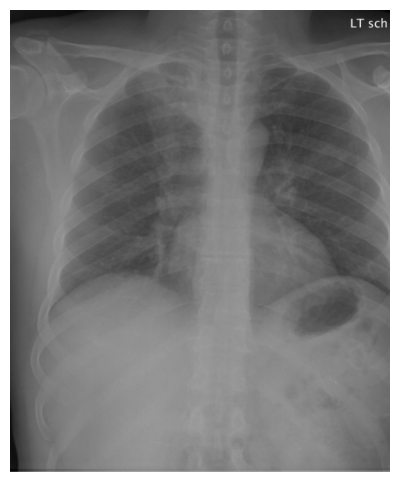

Generated report (beam):
 Findings: seffusion


In [37]:
report_beam = trainer.generate_report_manual_optimized(
    image_input=["/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1000_IM-0003-1001.png"],
    show_image=True,
    generation_config=generation_config_beam,
)

print("Generated report (beam):\n", report_beam)

In [38]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import random

def evaluate_on_val_samples(trainer, val_loader, tokenizer, num_samples=5):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # Get a single batch from val_loader
    sample_batch = next(iter(val_loader))
    images_batch = sample_batch['images']  # (batch, max_views, 3, H, W)
    input_ids = sample_batch['input_ids']
    image_paths_batch = sample_batch['image_paths']  # list of lists

    total_samples = min(num_samples, images_batch.size(0))
    selected_indices = random.sample(range(images_batch.size(0)), total_samples)

    for idx in selected_indices:
        images_tensor_list = []
        pil_imgs = []
        # Visualize all views per sample, skip padded views if a view_mask exists
        if 'view_mask' in sample_batch:
            view_mask = sample_batch['view_mask'][idx]  # (max_views,)
        else:
            view_mask = [1] * images_batch.size(1)
        for view_idx in range(images_batch.size(1)):
            if view_mask[view_idx] == 0:
                continue  # skip padded images
            image_tensor = images_batch[idx, view_idx].cpu()
            image_disp = (image_tensor * std) + mean
            image_disp = torch.clamp(image_disp, 0, 1)
            pil_img = transforms.ToPILImage()(image_disp)
            pil_imgs.append(pil_img)
            images_tensor_list.append(image_tensor)

        # Plot all views in a row
        num_views = len(pil_imgs)
        plt.figure(figsize=(5 * num_views, 5))
        for i, img in enumerate(pil_imgs):
            plt.subplot(1, num_views, i+1)
            plt.imshow(img)
            plt.title(f"View {i+1}")
            plt.axis('off')
        plt.show()

        # Decode ground truth report
        ground_truth_ids = input_ids[idx]
        ground_truth_report = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

        # Generate report from all views using robust_generate_radiology_report
        generated_report = trainer.generate_report_manual_optimized(
            image_input=pil_imgs,
            generation_config=generation_config_sampling,
        
        )
        generated_report_v2 = trainer.generate_report_manual_optimized(
            image_input=pil_imgs,
            generation_config=generation_config_creative,
        
        )
        generated_report_v3 = trainer.generate_report_manual_optimized(
            image_input=pil_imgs,
            generation_config=generation_config_beam,
        
        )
        generated_report_v4 = trainer.generate_report_manual_optimized(
            image_input=pil_imgs,
            generation_config=generation_config_refined,
        
        )
        generated_report_v5 = trainer.generate_report_manual_optimized(
            image_input=pil_imgs,
            generation_config=generation_config_clinical,
        
        )


        print(f"\n--- Ground Truth Report ---\n{ground_truth_report.strip()}")
        print(f"\n--- Generated Report-generation_config_sampling ---\n{generated_report.strip()}")
        print(f"\n--- Generated Report_v2-generation_config_creative ---\n{generated_report_v2.strip()}")
        print(f"\n--- Generated Report_v3 -generation_config_beam---\n{generated_report_v3.strip()}")
        print(f"\n--- Generated Report_v4 -generation_config_refined---\n{generated_report_v4.strip()}")
        print(f"\n--- Generated Report_v5 -generation_config_clinical---\n{generated_report_v5.strip()}")
        print("-" * 80)

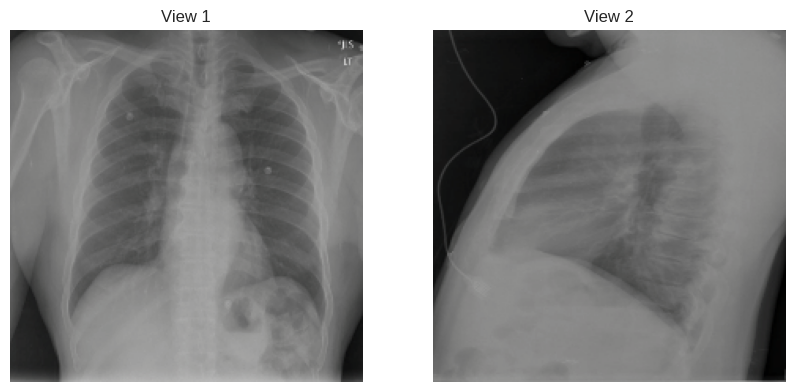


--- Ground Truth Report ---
cardiomediastinal silhouette demonstrates normal heart size with tortuosity and atherosclerosis of the thoracic aorta . no focal consolidation , pneumothorax , or pleural effusion . no acute bony abnormality identified . multilevel degenerative disc disease of the thoracic spine noted .  no acute cardiopulmonary abnormality .

--- Generated Report-generation_config_sampling ---
Findings: acuteeffusioncardiseffusionacutecardi  .acutepneumothoraxages s complexities  s oss . pneumothorax  . . ss s pulmonarypneumothorax effusions   cardisspulmonary  .ssutral Public acute effusions s   . cardieffusioneffusion seffusionscardieffusioncardi s acute mediastinalsacute effusions s effusion ss . s . pneumothorax . cardi s jQuery acutemediastinaleffusion  s  acuteeffusion    effusion ssconsolidationssacute sacute  pneumothorax . effusion seffusion      acuteacutecardissconsolidationacute  effusion  effusion  acutescardi sacuteeffusionsseffusions  ss     laps ss  effusio

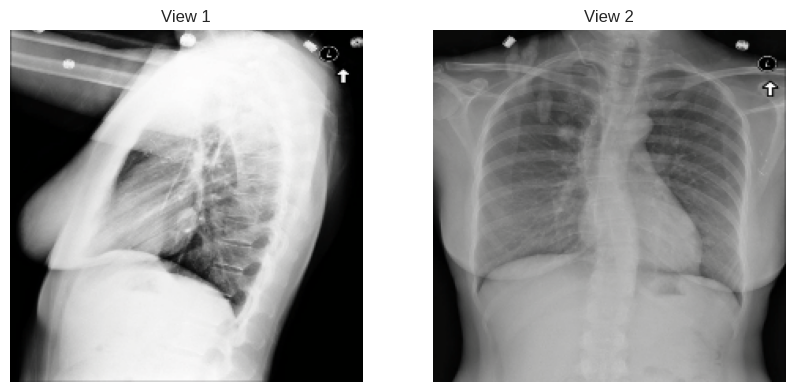


--- Ground Truth Report ---
there are bilateral pulmonary nodules whose appearances suggest metastatic disease to lungs . in the right lung , there is a 1 . 9 x 2 . 1 cm nodule overlying the posterior right 6th rib . there is a 1 . 0 x 1 . 2 cm nodule above this in the interspace between the posterior 5th and 6th ribs on the right . there is a 1 . 0 x 1 . 1 cm nodule projecting through the left 9th and 10th interspaces on the pa view . if not already performed , contrast-enhanced would be suited to evaluate these findings . there are no focal airspace opacities to suggest pneumonia . to the stomach contours appear grossly clear . heart size and pulmonary appear normal . there are left-sided axillary clips . there is a right internal jugular central catheter , the distal tip in right atrium .  1 . bilateral pulmonary nodules suggesting pulmonary metastases 2 . right internal jugular central catheter , the distal tip in the r

--- Generated Report-generation_config_sampling ---
Findings

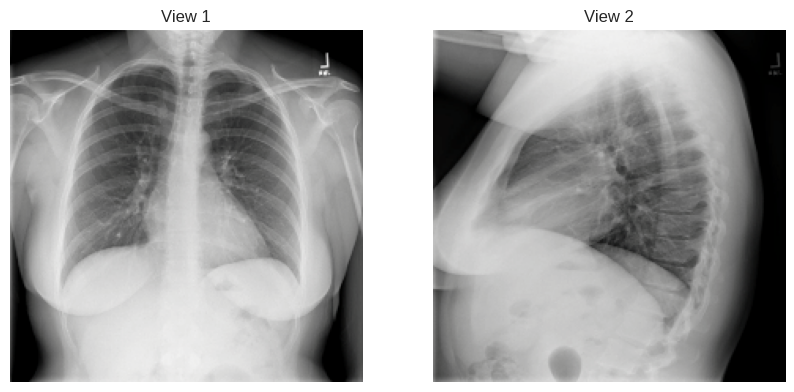


--- Ground Truth Report ---
the lungs and pleural spaces show no acute abnormality . heart size and pulmonary vascularity within normal limits .  1 . no acute pulmonary abnormality .

--- Generated Report-generation_config_sampling ---
Findings: .scardiacutecardi ageseffusionagesssonssssmediastinalscardiseffusions   . ss acute  .effusion Organcardi   .pneumothoraxs sacute . spneumothoraxcardi  spulmonary effusioneffusion s lapss . sss  s spneumothoraxscardi s s seffusioneffusioneffusion spneumothorax  .ss  effusion pneumothorax  .scardipulmonary overl  .effusionacute  scardi .acuteeffusionacuteeffusion   sacuteagessss  s  s kWh . .effusion effusion s pneumothorax    .s . .cardi scardi  acutecardi   cardis mediastinalsacute  effusioncardipulmonary   effusioneffusioneffusionsens  . effusionseffusionacutepneumothoraxacuteacuteeffusions  seffusions effusion seffusion effusionacutescardiss     ss .s acutecardi cardi   ${seffusion   cardi  effusions effusioncardi sconsolidation scardicardi 

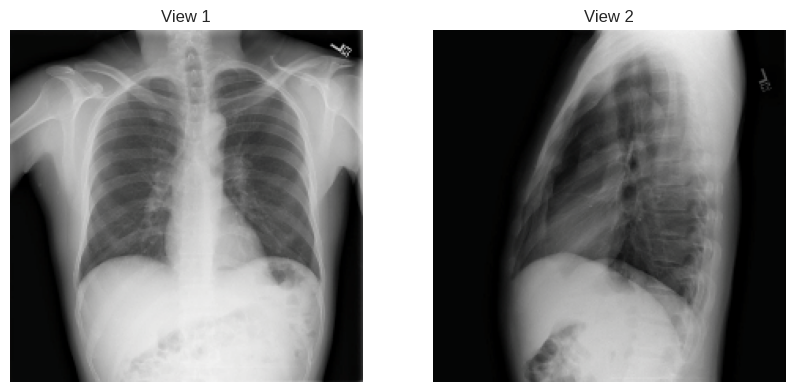


--- Ground Truth Report ---
heart size within normal limits , stable mediastinal and hilar contours . no alveolar consolidation , no findings of pleural effusion or pulmonary edema . no pneumothorax . small rounded bilateral axillary densities not seen on the previous exam most suggestive of artifacts , healed right lateral 10th rib fracture noted . .  no acute cardiopulmonary findings

--- Generated Report-generation_config_sampling ---
Findings: sacute  .cardi  .effusions  . s pneumothorax  .consolidation . effusioncardissseffusion pneumothoraxages ss   s  . . s effusionacute  acuteacutepneumothorax . s s seffusion acute  seffusion  mediastinal .cardi spulmonarysseffusion seffusion effusion  complexities .effusion  effusion  effusions  effusionacutecardisseffusionacute sdebug s  acuteacute sssacute .effusion sacute  cardi  acute cardi effusions sseffusionrespective    s s  .cardi .s cardi  .s acute sspulmonaryseffusioncardi acute ss cardis seffusionscardispneumothoraxeffusionacutes 

In [39]:
evaluate_on_val_samples(trainer, test_loader, tokenizer, num_samples=5)

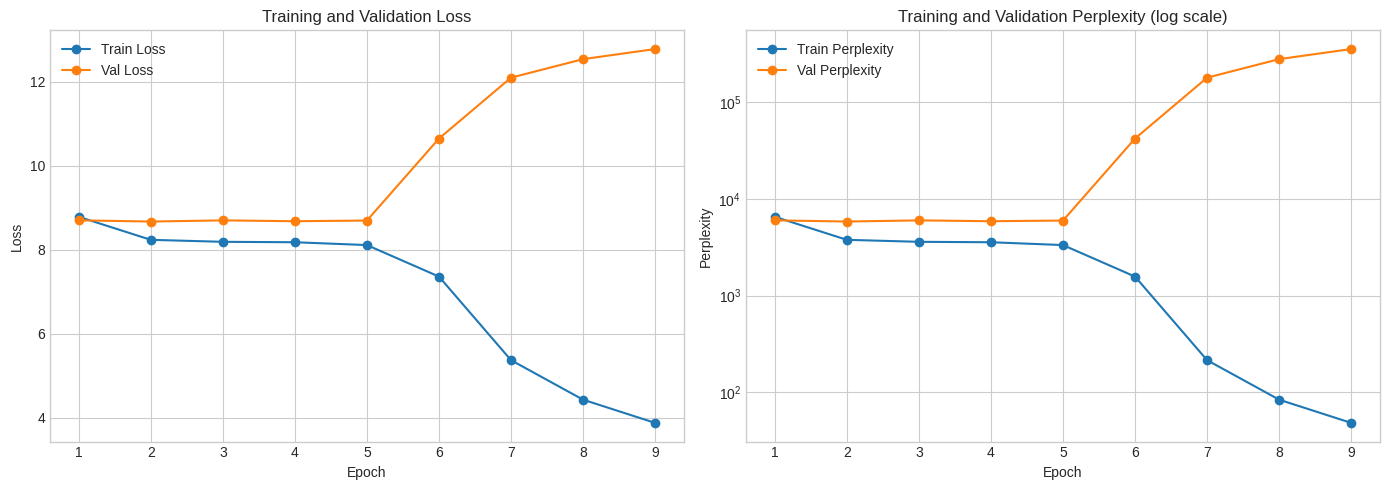

In [40]:
trainer.plot_loss_and_perplexity()

In [41]:
# import re
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from tqdm.auto import tqdm
# from PIL import Image
# from sklearn.metrics import classification_report, multilabel_confusion_matrix
# import nltk
# from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# from nltk.translate.meteor_score import single_meteor_score
# from nltk.tokenize import word_tokenize
# from rouge_score import rouge_scorer

# # Download necessary NLTK data (only needs to be done once)
# nltk.download('punkt', quiet=True)
# nltk.download('wordnet', quiet=True)
# # --- 1. Constants and Label Extraction Logic (Unchanged) ---
# # (Make sure these are defined in your environment)

# CHEXPERT_LABELS = [
#     "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion",
#     "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax",
#     "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices", "No Finding"
# ]

# PATTERNS = {
#     "Cardiomegaly": [r"cardiomegaly", r"enlarged heart"],
#     "Pleural Effusion": [r"pleural effusion", r"fluid in the pleura"],
#     "Atelectasis": [r"atelectasis", r"lung collapse"],
#     "Pneumonia": [r"pneumonia", r"infected lung"],
#     "Edema": [r"pulmonary edema", r"lung edema"],
#     "Pneumothorax": [r"pneumothorax", r"collapsed lung"],
#     "Fracture": [r"fracture", r"broken rib"],
#     "Consolidation": [r"consolidation"],
#     "Lung Opacity": [r"opacity"],
# }
# NEGATIONS = [r"\bno\b", r"without", r"absent", r"negative for"]

# def extract_labels(report: str):
#     report = report.lower()
#     labels = {label: 0 for label in CHEXPERT_LABELS}
#     any_positive = False
    
#     for label, patterns in PATTERNS.items():
#         for pat in patterns:
#             for match in re.finditer(pat, report):
#                 start = max(0, match.start() - 25)
#                 context = report[start:match.start()]
#                 if not any(re.search(n, context) for n in NEGATIONS):
#                     labels[label] = 1
#                     any_positive = True
#                     break
#             if labels[label] == 1:
#                 break
    
#     labels["No Finding"] = 1 if not any_positive else 0
#     return labels

# # --- 2. Core Functions (Modified and Organized) ---

# def evaluate_clinical_accuracy(dataloader, trainer, tokenizer, generation_config, label_extractor, device, max_samples=None):
#     """
#     Evaluates BOTH clinical accuracy and linguistic metrics in a single pass.
    
#     Returns:
#         A classification report string (for clinical accuracy).
#         A pandas Series with average linguistic scores.
#         A DataFrame with all raw reports and labels for analysis.
#         The raw numpy arrays y_true and y_pred for plotting.
#     """
#     all_gt_labels = []
#     all_pred_labels = []
#     all_gt_reports = []
#     all_pred_reports = []
    
#     # --- NEW: List to store linguistic scores for each sample ---
#     linguistic_scores = []
    
#     # Setup for linguistic metrics
#     rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
#     smoothie = SmoothingFunction().method1

#     sample_count = 0
#     for batch in tqdm(dataloader, desc="Running Full Evaluation"):
#         gt_labels_batch = batch['chexpert_labels']
#         image_paths_list = batch['image_paths']
#         input_ids_batch = batch['input_ids']

#         for i in range(len(image_paths_list)):
#             if max_samples and sample_count >= max_samples:
#                 break
            
#             # --- Part 1: Clinical Accuracy (as before) ---
#             gt_labels_vector = (gt_labels_batch[i].numpy() > 0).astype(int)
#             gt_input_ids = input_ids_batch[i]
#             gt_input_ids_filtered = gt_input_ids[gt_input_ids != tokenizer.pad_token_id]
#             gt_report = tokenizer.decode(gt_input_ids_filtered, skip_special_tokens=True)
            
#             pil_imgs = [Image.open(p).convert('RGB') for p in image_paths_list[i]]
#             generated_report = trainer.generate_report_manual_optimized(
#                 pil_imgs,
#                 generation_config=generation_config
#             )
#             pred_labels_dict = label_extractor(generated_report)
#             pred_labels_vector = np.array([pred_labels_dict[label] for label in CHEXPERT_LABELS])
            
#             all_gt_reports.append(gt_report)
#             all_pred_reports.append(generated_report)
#             all_gt_labels.append(gt_labels_vector)
#             all_pred_labels.append(pred_labels_vector)
            
#             # --- Part 2: Linguistic Metrics Calculation ---
#             # Tokenize for BLEU and METEOR
#             ref_tokens = word_tokenize(gt_report.lower())
#             hyp_tokens = word_tokenize(generated_report.lower())

#             if hyp_tokens: # Avoid errors on empty generated reports
#                 bleu1 = sentence_bleu([ref_tokens], hyp_tokens, weights=(1,0,0,0), smoothing_function=smoothie)
#                 bleu2 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5,0.5,0,0), smoothing_function=smoothie)
#                 bleu3 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33,0.33,0.33,0), smoothing_function=smoothie)
#                 bleu4 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)
#                 meteor = single_meteor_score(ref_tokens, hyp_tokens)
#                 rouge_l = rouge.score(gt_report, generated_report)['rougeL'].fmeasure
                
#                 linguistic_scores.append({
#                     'BLEU-1': bleu1, 'BLEU-2': bleu2, 'BLEU-3': bleu3, 'BLEU-4': bleu4,
#                     'METEOR': meteor, 'ROUGE-L': rouge_l
#                 })

#             sample_count += 1
        
#         if max_samples and sample_count >= max_samples:
#             break
            
#     # --- Final Aggregation ---
#     y_true = np.array(all_gt_labels)
#     y_pred = np.array(all_pred_labels)
    
#     clinical_report = classification_report(
#         y_true, y_pred, target_names=CHEXPERT_LABELS, zero_division=0
#     )
    
#     detailed_df = pd.DataFrame({
#         'ground_truth_report': all_gt_reports,
#         'generated_report': all_pred_reports,
#         'ground_truth_labels': list(y_true),
#         'predicted_labels': list(y_pred)
#     })
    
#     # Calculate average linguistic scores
#     avg_linguistic_scores = pd.DataFrame(linguistic_scores).mean()
    
#     return clinical_report, avg_linguistic_scores, detailed_df, y_true, y_pred


# def plot_confusion_matrices(y_true, y_pred, title="Per-Class Confusion Matrices"):
#     """Generates and displays a grid of confusion matrices."""
#     mcm = multilabel_confusion_matrix(y_true, y_pred)
    
#     rows, cols = 3, 5
#     fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
#     fig.suptitle(title, fontsize=24)
    
#     for i, label_name in enumerate(CHEXPERT_LABELS):
#         if i >= rows * cols: break
        
#         ax = axes[i // cols, i % cols]
#         cm = mcm[i]  # [[TN, FP], [FN, TP]]
        
#         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
#                     xticklabels=['Predicted Negative', 'Predicted Positive'],
#                     yticklabels=['True Negative', 'True Positive'])
        
#         ax.set_title(label_name, fontsize=14)
#         ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

#     # Hide unused subplots
#     for i in range(len(CHEXPERT_LABELS), rows * cols):
#         ax = axes[i // cols, i % cols]
#         ax.axis('off')
        
#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.show()

# # --- 3. Main Workflow Function ---

# def run_and_visualize_evaluation(
#     title,
#     output_csv_filename,
#     dataloader,
#     trainer,
#     tokenizer,
#     generation_config,
#     max_samples=None
# ):
#     """
#     Runs the full evaluation pipeline, now including linguistic metrics.
#     """
#     print(f"\n{'='*25}\n--- Running Full Evaluation: {title} ---\n{'='*25}")

#     # Step 1: Run the evaluation to get all metrics and raw data
#     clinical_report, linguistic_summary, detailed_df, y_true, y_pred = evaluate_clinical_accuracy(
#         dataloader=dataloader,
#         trainer=trainer,
#         tokenizer=tokenizer,
#         generation_config=generation_config,
#         label_extractor=extract_labels,
#         device=DEVICE, 
#         max_samples=max_samples
#     )

#     # Step 2: Print the Clinical Accuracy Report
#     print("\n--- Clinical Accuracy Report ---")
#     print(clinical_report)

#     # Step 3: Print the Linguistic Metrics Summary
#     print("\n--- Linguistic Metrics Report (Average Scores) ---")
#     print(linguistic_summary.round(4).to_string()) # .round(4) for cleaner output

#     # Step 4: Save the detailed reports to a CSV file
#     detailed_df.to_csv(output_csv_filename, index=False)
#     print(f"\n✅ Detailed reports and labels saved to '{output_csv_filename}'")

#     # Step 5: Plot and display the confusion matrices
#     plot_confusion_matrices(y_true, y_pred, title=f"Confusion Matrices: {title}")


In [42]:
# run_and_visualize_evaluation(
#     title="Beam Search Generation",
#     output_csv_filename="clinical_accuracy_beam_search.csv",
#     dataloader=val_loader,
#     trainer=trainer,
#     tokenizer=tokenizer,
#     generation_config=generation_config_beam,
#     # max_samples=5 # Optional: set a number for faster testing
# )



In [43]:
# run_and_visualize_evaluation(
#     title="clinical Generation",
#     output_csv_filename="clinical_accuracy_clinical_search.csv",
#     dataloader=val_loader,
#     trainer=trainer,
#     tokenizer=tokenizer,
#     generation_config=generation_config_clinical,
#     # max_samples=5 # Optional: set a number for faster testing
# )

In [44]:
# run_and_visualize_evaluation(
#     title="generation_config_refined Generation",
#     output_csv_filename="generation_config_refined_search.csv",
#     dataloader=val_loader,
#     trainer=trainer,
#     tokenizer=tokenizer,
#     generation_config=generation_config_refined,
#     # max_samples=5 # Optional: set a number for faster testing
# )